In [2]:
# 1) Imports and plotting config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

shape: (89639, 10)
columns: ['Participant ID', 'Participant name', 'Group', 'Date', 'Steps', 'Minutessedentary', 'Minuteslightlyactive', 'Minutesfairlyactive', 'Minutesveryactive', 'Total Active Minutes (fairly + very)']
total duplicates: 0


C:\Users\chris\AppData\Local\Temp\ipykernel_15300\254642664.py:27: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_work['Date'] = pd.to_datetime(df_work['Date'], errors='coerce', infer_datetime_format=True)


Participant ID
33      451
54      451
9       439
12      439
10      439
11      439
2031    432
8       431
2008    430
108     409
dtype: int64

unique participants: 243
min date: 2022-06-13 00:00:00 max date: 2025-04-30 00:00:00
unique dates: 908
unparsed/NaT dates: 0
rows with 0 steps and >=1400 sedentary minutes: 21553


,Participant ID,Participant name,Group,Date,Steps,Minutessedentary,Minuteslightlyactive,Minutesfairlyactive,Minutesveryactive,Total Active Minutes (fairly + very)
0,100,user user 100,mLife (control),2022-06-13,0,1440,0,0,0,0
1,105,user user 105,mLife (control),2022-06-13,0,1440,0,0,0,0
2,106,user user 106,mLife (control),2022-06-13,0,1440,0,0,0,0
3,108,user user 108,mLife (control),2022-06-13,0,1440,0,0,0,0
4,109,user user 109,mLife (control),2022-06-13,0,1440,0,0,0,0


count     89639.000000
mean       5241.990172
std        5564.988501
min           0.000000
1%            0.000000
5%            0.000000
25%          16.000000
50%        4534.000000
75%        8186.000000
95%       13792.000000
99%       18809.240000
max      267947.000000
Name: Steps, dtype: float64

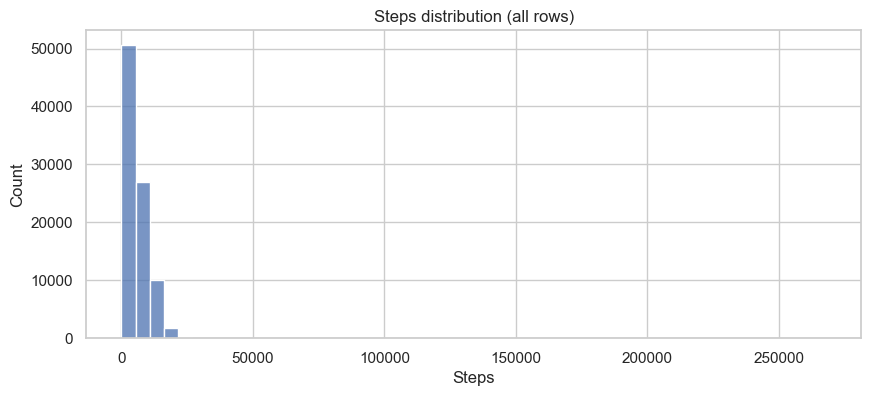

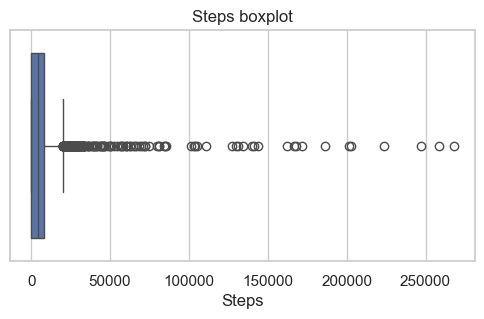

In [7]:
# 2) Load the CSV (adjust the path if you move the notebook)
csv_path = '../data/raw/steps.csv'
# read as strings first to inspect; parse dates later
df = pd.read_csv(csv_path, dtype=str)
# keep a copy of the original raw frame for reference
df_raw = df.copy()

# 3) Quick preview and basic info: shape, columns, sample types
print('shape:', df_raw.shape)
print('columns:', list(df_raw.columns))
# show a transposed sample for easier reading in notebooks
df_raw.iloc[:5, :].T

# 4) Convert appropriate columns to numeric and parse dates robustly
# We'll attempt common conversions but keep failures visible
conversions = {}
for col in df_raw.columns:
    if col.lower() in ('participant id', 'steps') or 'minute' in col.lower() or 'total' in col.lower():
        conversions[col] = pd.to_numeric(df_raw[col], errors='coerce')
    else:
        conversions[col] = df_raw[col]

# Build a working dataframe with parsed types where possible
df_work = pd.DataFrame(conversions)
# Parse the Date column (common formats MM/DD/YYYY present in the file)
if 'Date' in df_work.columns:
    df_work['Date'] = pd.to_datetime(df_work['Date'], errors='coerce', infer_datetime_format=True)
else:
    print('Warning: no Date column found')

# 5) Schema summary: dtypes, missing counts, and percent missing
dtypes = df_work.dtypes.astype(str)
missing = df_work.isna().sum()
missing_pct = (missing / len(df_work)) * 100
schema = pd.DataFrame({'dtype': dtypes, 'missing': missing, 'missing_pct': missing_pct})
schema

# 6) Numeric summary for numeric columns
df_work.select_dtypes(include=[np.number]).describe().T

# 7) Duplicate rows check
print('total duplicates:', df_work.duplicated().sum())
# show a few duplicate examples if present
if df_work.duplicated().any():
    display(df_work[df_work.duplicated(keep=False)].head(10))

# 8) Participant-level record counts and coverage
if 'Participant ID' in df_work.columns:
    counts = df_work.groupby('Participant ID').size().sort_values(ascending=False)
    display(counts.head(10))
    print('unique participants:', counts.size)
else:
    print('No Participant ID column found')

# 9) Date range and missing dates
if 'Date' in df_work.columns:
    print('min date:', df_work['Date'].min(), 'max date:', df_work['Date'].max())
    print('unique dates:', df_work['Date'].nunique())
    # rows with unparsed dates
    print('unparsed/NaT dates:', df_work['Date'].isna().sum())
else:
    print('No Date column to inspect')

# 10) Check for likely non-wear / missing-day rows
# e.g., Steps == 0 and Minutessedentary close to 1440 (all-day sedentary)
scol = 'Steps' if 'Steps' in df_work.columns else None
sedcol = next((c for c in df_work.columns if 'sedentary' in c.lower()), None)
if scol and sedcol:
    mask = (df_work[scol] == 0) & (pd.to_numeric(df_work[sedcol], errors='coerce') >= 1400)
    print('rows with 0 steps and >=1400 sedentary minutes:', mask.sum())
    display(df_work[mask].head(5))
else:
    print('Steps or sedentary-minute column not found')

# 11) Steps distribution and outliers
if scol:
    s = pd.to_numeric(df_work[scol], errors='coerce')
    display(s.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
    plt.figure(figsize=(10,4))
    sns.histplot(s.dropna(), bins=50, kde=False)
    plt.title('Steps distribution (all rows)')
    plt.show()
    plt.figure(figsize=(6,3))
    sns.boxplot(x=s.dropna())
    plt.title('Steps boxplot')
    plt.show()
else:
    print('No Steps column to inspect')

In [9]:
# Diagnostic: print key in-memory summaries to help review outputs from the previous cell
try:
    print('df_work.shape ->', df_work.shape)
    print('\nSchema (first 20 rows):')
    display(schema.head(20))
    print('\nParticipant counts (top 10):')
    try:
        display(counts.head(10))
    except NameError:
        print('counts not defined')
    print('\nMask (likely non-wear) summary:')
    try:
        print('mask.sum() ->', int(mask.sum()))
        display(df_work[mask].head(10))
    except NameError:
        print('mask not defined')
    print('\nSteps summary:')
    try:
        display(s.describe())
    except NameError:
        print('s not defined')
    if 'Date' in df_work.columns:
        print('\nUnique dates:', df_work['Date'].nunique())
        print('Unparsed/NaT dates:', int(df_work['Date'].isna().sum()))
except Exception as e:
    print('Diagnostic cell failed with error:', repr(e))

df_work.shape -> (89639, 10)

Schema (first 20 rows):


,dtype,missing,missing_pct
Participant ID,int64,0,0.0
Participant name,object,0,0.0
Group,object,0,0.0
Date,datetime64[ns],0,0.0
Steps,int64,0,0.0
Minutessedentary,int64,0,0.0
Minuteslightlyactive,int64,0,0.0
Minutesfairlyactive,int64,0,0.0
Minutesveryactive,int64,0,0.0
Total Active Minutes (fairly + very),int64,0,0.0



Participant counts (top 10):


Participant ID
33      451
54      451
9       439
12      439
10      439
11      439
2031    432
8       431
2008    430
108     409
dtype: int64


Mask (likely non-wear) summary:
mask.sum() -> 21553


,Participant ID,Participant name,Group,Date,Steps,Minutessedentary,Minuteslightlyactive,Minutesfairlyactive,Minutesveryactive,Total Active Minutes (fairly + very)
0,100,user user 100,mLife (control),2022-06-13,0,1440,0,0,0,0
1,105,user user 105,mLife (control),2022-06-13,0,1440,0,0,0,0
2,106,user user 106,mLife (control),2022-06-13,0,1440,0,0,0,0
3,108,user user 108,mLife (control),2022-06-13,0,1440,0,0,0,0
4,109,user user 109,mLife (control),2022-06-13,0,1440,0,0,0,0
5,110,user user 110,mLife (control),2022-06-13,0,1440,0,0,0,0
7,113,user user 113,mLife (control),2022-06-13,0,1440,0,0,0,0
8,115,user user 115,mLife (control),2022-06-13,0,1440,0,0,0,0
10,119,user user 119,mLife (control),2022-06-13,0,1440,0,0,0,0
11,120,user user 120,mLife (control),2022-06-13,0,1440,0,0,0,0



Steps summary:


count     89639.000000
mean       5241.990172
std        5564.988501
min           0.000000
25%          16.000000
50%        4534.000000
75%        8186.000000
max      267947.000000
Name: Steps, dtype: float64


Unique dates: 908
Unparsed/NaT dates: 0


In [10]:
# Investigate extreme step outliers
thresholds = [50000, 100000]
for t in thresholds:
    print(f"Rows with Steps > {t}:", (df_work['Steps'] > t).sum())
    display(df_work.loc[df_work['Steps'] > t, ['Participant ID','Participant name','Group','Date','Steps']].sort_values('Steps', ascending=False).head(20))

# Show participants with the largest single-day steps
top = df_work[['Participant ID','Participant name','Date','Steps']].sort_values('Steps', ascending=False).head(50)
display(top)

# Count how many unique participants appear in the top-outlier set
u = top['Participant ID'].nunique()
print('unique participants in top 50 step records:', u)

Rows with Steps > 50000: 51


,Participant ID,Participant name,Group,Date,Steps
65760,2109,user user 2109,mLife+Points2,2024-01-09,267947
66546,2109,user user 2109,mLife+Points2,2024-01-15,258374
66939,2109,user user 2109,mLife+Points2,2024-01-18,247426
66808,2109,user user 2109,mLife+Points2,2024-01-17,223460
67594,2109,user user 2109,mLife+Points2,2024-01-23,202872
66677,2109,user user 2109,mLife+Points2,2024-01-16,201433
69035,2109,user user 2109,mLife+Points2,2024-02-03,186261
83184,2109,user user 2109,mLife+Points2,2024-05-23,171685
67463,2109,user user 2109,mLife+Points2,2024-01-22,167664
66284,2109,user user 2109,mLife+Points2,2024-01-13,166558


Rows with Steps > 100000: 23


,Participant ID,Participant name,Group,Date,Steps
65760,2109,user user 2109,mLife+Points2,2024-01-09,267947
66546,2109,user user 2109,mLife+Points2,2024-01-15,258374
66939,2109,user user 2109,mLife+Points2,2024-01-18,247426
66808,2109,user user 2109,mLife+Points2,2024-01-17,223460
67594,2109,user user 2109,mLife+Points2,2024-01-23,202872
66677,2109,user user 2109,mLife+Points2,2024-01-16,201433
69035,2109,user user 2109,mLife+Points2,2024-02-03,186261
83184,2109,user user 2109,mLife+Points2,2024-05-23,171685
67463,2109,user user 2109,mLife+Points2,2024-01-22,167664
66284,2109,user user 2109,mLife+Points2,2024-01-13,166558


,Participant ID,Participant name,Date,Steps
65760,2109,user user 2109,2024-01-09,267947
66546,2109,user user 2109,2024-01-15,258374
66939,2109,user user 2109,2024-01-18,247426
66808,2109,user user 2109,2024-01-17,223460
67594,2109,user user 2109,2024-01-23,202872
66677,2109,user user 2109,2024-01-16,201433
69035,2109,user user 2109,2024-02-03,186261
83184,2109,user user 2109,2024-05-23,171685
67463,2109,user user 2109,2024-01-22,167664
66284,2109,user user 2109,2024-01-13,166558


unique participants in top 50 step records: 4


In [11]:
# Show top 20 outliers and ±7 day windows for each outlier (participant context)
top20 = df_work[['Participant ID','Participant name','Group','Date','Steps']].sort_values('Steps', ascending=False).head(20).reset_index(drop=True)
print('Top 20 outliers:')
display(top20)

# For each outlier row, show the participant's ±7 days around that date
from pandas import Timedelta
for idx, row in top20.iterrows():
    pid = row['Participant ID']
    dt = row['Date']
    print('\n---- Outlier', idx+1, f"(Participant {pid}, date={dt.date()}, Steps={int(row['Steps'])}) ----")
    window = df_work[(df_work['Participant ID']==pid) & (df_work['Date']>= (dt - Timedelta(days=7))) & (df_work['Date']<= (dt + Timedelta(days=7)))].sort_values('Date')
    display(window[['Participant ID','Date','Steps']])

Top 20 outliers:


,Participant ID,Participant name,Group,Date,Steps
0,2109,user user 2109,mLife+Points2,2024-01-09,267947
1,2109,user user 2109,mLife+Points2,2024-01-15,258374
2,2109,user user 2109,mLife+Points2,2024-01-18,247426
3,2109,user user 2109,mLife+Points2,2024-01-17,223460
4,2109,user user 2109,mLife+Points2,2024-01-23,202872
5,2109,user user 2109,mLife+Points2,2024-01-16,201433
6,2109,user user 2109,mLife+Points2,2024-02-03,186261
7,2109,user user 2109,mLife+Points2,2024-05-23,171685
8,2109,user user 2109,mLife+Points2,2024-01-22,167664
9,2109,user user 2109,mLife+Points2,2024-01-13,166558



---- Outlier 1 (Participant 2109, date=2024-01-09, Steps=267947) ----


,Participant ID,Date,Steps
64843,2109,2024-01-02,31870
64974,2109,2024-01-03,10305
65105,2109,2024-01-04,18042
65236,2109,2024-01-05,24537
65367,2109,2024-01-06,3003
65498,2109,2024-01-07,13002
65629,2109,2024-01-08,143518
65760,2109,2024-01-09,267947
65891,2109,2024-01-10,20027
66022,2109,2024-01-11,80929



---- Outlier 2 (Participant 2109, date=2024-01-15, Steps=258374) ----


,Participant ID,Date,Steps
65629,2109,2024-01-08,143518
65760,2109,2024-01-09,267947
65891,2109,2024-01-10,20027
66022,2109,2024-01-11,80929
66153,2109,2024-01-12,5047
66284,2109,2024-01-13,166558
66415,2109,2024-01-14,101621
66546,2109,2024-01-15,258374
66677,2109,2024-01-16,201433
66808,2109,2024-01-17,223460



---- Outlier 3 (Participant 2109, date=2024-01-18, Steps=247426) ----


,Participant ID,Date,Steps
66022,2109,2024-01-11,80929
66153,2109,2024-01-12,5047
66284,2109,2024-01-13,166558
66415,2109,2024-01-14,101621
66546,2109,2024-01-15,258374
66677,2109,2024-01-16,201433
66808,2109,2024-01-17,223460
66939,2109,2024-01-18,247426
67070,2109,2024-01-19,134341
67201,2109,2024-01-20,71132



---- Outlier 4 (Participant 2109, date=2024-01-17, Steps=223460) ----


,Participant ID,Date,Steps
65891,2109,2024-01-10,20027
66022,2109,2024-01-11,80929
66153,2109,2024-01-12,5047
66284,2109,2024-01-13,166558
66415,2109,2024-01-14,101621
66546,2109,2024-01-15,258374
66677,2109,2024-01-16,201433
66808,2109,2024-01-17,223460
66939,2109,2024-01-18,247426
67070,2109,2024-01-19,134341



---- Outlier 5 (Participant 2109, date=2024-01-23, Steps=202872) ----


,Participant ID,Date,Steps
66677,2109,2024-01-16,201433
66808,2109,2024-01-17,223460
66939,2109,2024-01-18,247426
67070,2109,2024-01-19,134341
67201,2109,2024-01-20,71132
67332,2109,2024-01-21,130151
67463,2109,2024-01-22,167664
67594,2109,2024-01-23,202872
67725,2109,2024-01-24,131134
67856,2109,2024-01-25,83930



---- Outlier 6 (Participant 2109, date=2024-01-16, Steps=201433) ----


,Participant ID,Date,Steps
65760,2109,2024-01-09,267947
65891,2109,2024-01-10,20027
66022,2109,2024-01-11,80929
66153,2109,2024-01-12,5047
66284,2109,2024-01-13,166558
66415,2109,2024-01-14,101621
66546,2109,2024-01-15,258374
66677,2109,2024-01-16,201433
66808,2109,2024-01-17,223460
66939,2109,2024-01-18,247426



---- Outlier 7 (Participant 2109, date=2024-02-03, Steps=186261) ----


,Participant ID,Date,Steps
68118,2109,2024-01-27,71968
68249,2109,2024-01-28,64807
68380,2109,2024-01-29,127405
68511,2109,2024-01-30,81305
68642,2109,2024-01-31,68446
68773,2109,2024-02-01,45729
68904,2109,2024-02-02,49681
69035,2109,2024-02-03,186261
69166,2109,2024-02-04,38317
69297,2109,2024-02-05,50217



---- Outlier 8 (Participant 2109, date=2024-05-23, Steps=171685) ----


,Participant ID,Date,Steps
82316,2109,2024-05-16,10356
82440,2109,2024-05-17,38139
82564,2109,2024-05-18,14487
82688,2109,2024-05-19,19989
82812,2109,2024-05-20,16668
82936,2109,2024-05-21,57126
83060,2109,2024-05-22,74725
83184,2109,2024-05-23,171685
83308,2109,2024-05-24,31080
83432,2109,2024-05-25,12933



---- Outlier 9 (Participant 2109, date=2024-01-22, Steps=167664) ----


,Participant ID,Date,Steps
66546,2109,2024-01-15,258374
66677,2109,2024-01-16,201433
66808,2109,2024-01-17,223460
66939,2109,2024-01-18,247426
67070,2109,2024-01-19,134341
67201,2109,2024-01-20,71132
67332,2109,2024-01-21,130151
67463,2109,2024-01-22,167664
67594,2109,2024-01-23,202872
67725,2109,2024-01-24,131134



---- Outlier 10 (Participant 2109, date=2024-01-13, Steps=166558) ----


,Participant ID,Date,Steps
65367,2109,2024-01-06,3003
65498,2109,2024-01-07,13002
65629,2109,2024-01-08,143518
65760,2109,2024-01-09,267947
65891,2109,2024-01-10,20027
66022,2109,2024-01-11,80929
66153,2109,2024-01-12,5047
66284,2109,2024-01-13,166558
66415,2109,2024-01-14,101621
66546,2109,2024-01-15,258374



---- Outlier 11 (Participant 2109, date=2024-02-06, Steps=162373) ----


,Participant ID,Date,Steps
68511,2109,2024-01-30,81305
68642,2109,2024-01-31,68446
68773,2109,2024-02-01,45729
68904,2109,2024-02-02,49681
69035,2109,2024-02-03,186261
69166,2109,2024-02-04,38317
69297,2109,2024-02-05,50217
69428,2109,2024-02-06,162373
69559,2109,2024-02-07,69642
69690,2109,2024-02-08,41443



---- Outlier 12 (Participant 2109, date=2024-01-08, Steps=143518) ----


,Participant ID,Date,Steps
64712,2109,2024-01-01,14205
64843,2109,2024-01-02,31870
64974,2109,2024-01-03,10305
65105,2109,2024-01-04,18042
65236,2109,2024-01-05,24537
65367,2109,2024-01-06,3003
65498,2109,2024-01-07,13002
65629,2109,2024-01-08,143518
65760,2109,2024-01-09,267947
65891,2109,2024-01-10,20027



---- Outlier 13 (Participant 2109, date=2024-06-16, Steps=141072) ----


,Participant ID,Date,Steps
85291,2109,2024-06-09,13512
85414,2109,2024-06-10,11148
85537,2109,2024-06-11,66338
85660,2109,2024-06-12,139858
85783,2109,2024-06-13,35787
85906,2109,2024-06-14,15012
86029,2109,2024-06-15,58092
86152,2109,2024-06-16,141072
86275,2109,2024-06-17,43756
86398,2109,2024-06-18,103681



---- Outlier 14 (Participant 2109, date=2024-06-12, Steps=139858) ----


,Participant ID,Date,Steps
84796,2109,2024-06-05,48944
84920,2109,2024-06-06,60698
85044,2109,2024-06-07,105432
85168,2109,2024-06-08,62388
85291,2109,2024-06-09,13512
85414,2109,2024-06-10,11148
85537,2109,2024-06-11,66338
85660,2109,2024-06-12,139858
85783,2109,2024-06-13,35787
85906,2109,2024-06-14,15012



---- Outlier 15 (Participant 2109, date=2024-01-19, Steps=134341) ----


,Participant ID,Date,Steps
66153,2109,2024-01-12,5047
66284,2109,2024-01-13,166558
66415,2109,2024-01-14,101621
66546,2109,2024-01-15,258374
66677,2109,2024-01-16,201433
66808,2109,2024-01-17,223460
66939,2109,2024-01-18,247426
67070,2109,2024-01-19,134341
67201,2109,2024-01-20,71132
67332,2109,2024-01-21,130151



---- Outlier 16 (Participant 2109, date=2024-01-24, Steps=131134) ----


,Participant ID,Date,Steps
66808,2109,2024-01-17,223460
66939,2109,2024-01-18,247426
67070,2109,2024-01-19,134341
67201,2109,2024-01-20,71132
67332,2109,2024-01-21,130151
67463,2109,2024-01-22,167664
67594,2109,2024-01-23,202872
67725,2109,2024-01-24,131134
67856,2109,2024-01-25,83930
67987,2109,2024-01-26,60163



---- Outlier 17 (Participant 2109, date=2024-01-21, Steps=130151) ----


,Participant ID,Date,Steps
66415,2109,2024-01-14,101621
66546,2109,2024-01-15,258374
66677,2109,2024-01-16,201433
66808,2109,2024-01-17,223460
66939,2109,2024-01-18,247426
67070,2109,2024-01-19,134341
67201,2109,2024-01-20,71132
67332,2109,2024-01-21,130151
67463,2109,2024-01-22,167664
67594,2109,2024-01-23,202872



---- Outlier 18 (Participant 2109, date=2024-01-29, Steps=127405) ----


,Participant ID,Date,Steps
67463,2109,2024-01-22,167664
67594,2109,2024-01-23,202872
67725,2109,2024-01-24,131134
67856,2109,2024-01-25,83930
67987,2109,2024-01-26,60163
68118,2109,2024-01-27,71968
68249,2109,2024-01-28,64807
68380,2109,2024-01-29,127405
68511,2109,2024-01-30,81305
68642,2109,2024-01-31,68446



---- Outlier 19 (Participant 2109, date=2024-05-30, Steps=110724) ----


,Participant ID,Date,Steps
83184,2109,2024-05-23,171685
83308,2109,2024-05-24,31080
83432,2109,2024-05-25,12933
83556,2109,2024-05-26,57549
83680,2109,2024-05-27,50541
83804,2109,2024-05-28,103185
83928,2109,2024-05-29,79533
84052,2109,2024-05-30,110724
84176,2109,2024-05-31,46128
84300,2109,2024-06-01,30708



---- Outlier 20 (Participant 2109, date=2024-06-07, Steps=105432) ----


,Participant ID,Date,Steps
84176,2109,2024-05-31,46128
84300,2109,2024-06-01,30708
84424,2109,2024-06-02,62760
84548,2109,2024-06-03,29472
84672,2109,2024-06-04,85150
84796,2109,2024-06-05,48944
84920,2109,2024-06-06,60698
85044,2109,2024-06-07,105432
85168,2109,2024-06-08,62388
85291,2109,2024-06-09,13512


In [12]:
# Extract Participant 2109 into a separate CSV and remove from df_work for re-inspection
pid = 2109
df_2109 = df_work[df_work['Participant ID']==pid].copy()
out_path = '../data/weird/steps_participant_2109.csv'
# ensure directory exists and write CSV
import os
os.makedirs(os.path.join('..','data','weird'), exist_ok=True)
df_2109.to_csv(out_path, index=False)
print('Wrote', len(df_2109), 'rows to', out_path)
# create df without participant 2109 for further analysis
df_no2109 = df_work[df_work['Participant ID']!=pid].copy()
print('Original df_work shape:', df_work.shape)
print('df_no2109 shape:', df_no2109.shape)

Wrote 383 rows to ../data/weird/steps_participant_2109.csv
Original df_work shape: (89639, 10)
df_no2109 shape: (89256, 10)


In [13]:
# Quick QA on df_no2109 (dataset without participant 2109)
try:
    print('df_no2109.shape ->', df_no2109.shape)
    # Steps summary
    s_no = pd.to_numeric(df_no2109['Steps'], errors='coerce')
    print('\nSteps summary (no participant 2109):')
    display(s_no.describe().to_frame(name='value'))
    # Outlier counts
    for t in (50000,100000):
        print(f"Rows with Steps > {t}:", (s_no > t).sum())
    # non-wear heuristic
    sedcol_no = next((c for c in df_no2109.columns if 'sedentary' in c.lower()), None)
    if sedcol_no is not None:
        mask_no = (s_no == 0) & (pd.to_numeric(df_no2109[sedcol_no], errors='coerce') >= 1400)
        print('\nLikely non-wear rows (Steps==0 & sedentary>=1400):', mask_no.sum())
    else:
        print('\nNo sedentary-minute column found')
    # minute-sum consistency
    minute_cols = [c for c in df_no2109.columns if 'minute' in c.lower() and 'total' not in c.lower()]
    if minute_cols:
        mins_sum = df_no2109[minute_cols].apply(pd.to_numeric, errors='coerce').sum(axis=1)
        print('\nRows with minute-sum > 1440:', (mins_sum > 1440).sum())
        print('Rows with minute-sum < 1200 (possible missing recording):', (mins_sum < 1200).sum())
    else:
        print('\nNo minute columns found to check')
    # Check Total Active Minutes consistency if available
    total_col = next((c for c in df_no2109.columns if 'total active' in c.lower()), None)
    fairly_col = next((c for c in df_no2109.columns if 'fairly' in c.lower()), None)
    very_col = next((c for c in df_no2109.columns if 'very' in c.lower()), None)
    if total_col and fairly_col and very_col:
        ta = pd.to_numeric(df_no2109[total_col], errors='coerce')
        fv = pd.to_numeric(df_no2109[fairly_col], errors='coerce') + pd.to_numeric(df_no2109[very_col], errors='coerce')
        mismatch = (ta != fv) & ~(ta.isna() & fv.isna())
        print('\nTotal Active Minutes mismatch rows:', mismatch.sum())
    else:
        print('\nTotal/fairly/very columns not all present for consistency check')
    # Duplicates and participant coverage
    print('\nExact duplicate rows (no2109):', df_no2109.duplicated().sum())
    if 'Participant ID' in df_no2109.columns:
        pc = df_no2109.groupby('Participant ID').size().sort_values(ascending=False)
        print('\nTop 10 participants by row count:')
        display(pc.head(10))
    # Date range and unique dates
    if 'Date' in df_no2109.columns:
        print('\nDate range (no2109):', df_no2109['Date'].min(), '->', df_no2109['Date'].max())
        print('Unique dates:', df_no2109['Date'].nunique())
    else:
        print('\nNo Date column present')
except Exception as e:
    print('QA cell failed:', repr(e))

df_no2109.shape -> (89256, 10)

Steps summary (no participant 2109):


,value
count,89256.000000
mean,5169.173165
std,4749.508499
min,0.000000
25%,12.000000
50%,4523.000000
75%,8169.000000
max,71951.000000


Rows with Steps > 50000: 3
Rows with Steps > 100000: 0

Likely non-wear rows (Steps==0 & sedentary>=1400): 21538

Rows with minute-sum > 1440: 0
Rows with minute-sum < 1200 (possible missing recording): 47514

Total Active Minutes mismatch rows: 0

Exact duplicate rows (no2109): 0

Top 10 participants by row count:


Participant ID
54      451
33      451
11      439
12      439
10      439
9       439
2031    432
8       431
2008    430
83      409
dtype: int64


Date range (no2109): 2022-06-13 00:00:00 -> 2025-04-30 00:00:00
Unique dates: 908


In [14]:
# A) Inspect remaining high-step rows (Steps > 50k) in df_no2109
high = df_no2109[pd.to_numeric(df_no2109['Steps'], errors='coerce') > 50000].copy()
print('Rows with Steps > 50k (count):', len(high))
if len(high):
    print('\nDistinct participants in high-steps:', high['Participant ID'].nunique())
    print('Participant ID counts:')
    display(high.groupby('Participant ID').size().sort_values(ascending=False))
    print('\nFull rows (sorted by Steps desc):')
    display(high.sort_values('Steps', ascending=False))
else:
    print('No rows > 50k found')

Rows with Steps > 50k (count): 3

Distinct participants in high-steps: 3
Participant ID counts:


Participant ID
62     1
68     1
105    1
dtype: int64


Full rows (sorted by Steps desc):


,Participant ID,Participant name,Group,Date,Steps,Minutessedentary,Minuteslightlyactive,Minutesfairlyactive,Minutesveryactive,Total Active Minutes (fairly + very)
21375,105,user user 105,mLife (control),2023-01-05,71951,769,208,0,8,8
22650,62,user user 62,mLife+Points,2023-01-17,56438,303,166,111,374,485
2430,68,user user 68,mLife (control),2022-07-06,52763,366,184,172,342,514


In [15]:
# Null out extreme Steps (>50k) in df_no2109 and save flagged rows + cleaned dataset
threshold = 50000
flagged = df_no2109[pd.to_numeric(df_no2109['Steps'], errors='coerce') > threshold].copy()
tmp_dir = os.path.join('..','data','tmp')
os.makedirs(tmp_dir, exist_ok=True)
flagged_path = os.path.join(tmp_dir, 'steps_no2109_flagged.csv')
flagged.to_csv(flagged_path, index=False)
print('Wrote flagged rows to', flagged_path, 'count =', len(flagged))
# set Steps to NaN in df_no2109 for flagged rows (in-place)
mask_extreme = pd.to_numeric(df_no2109['Steps'], errors='coerce') > threshold
df_no2109.loc[mask_extreme, 'Steps'] = np.nan
print('After nulling, extreme Steps count:', mask_extreme.sum())
# ensure cleaned dir exists and save cleaned df_no2109
cleaned_dir = os.path.join('..','data','cleaned')
os.makedirs(cleaned_dir, exist_ok=True)
cleaned_path = os.path.join(cleaned_dir, 'steps_no2109_cleaned.csv')
df_no2109.to_csv(cleaned_path, index=False)
print('Saved cleaned df_no2109 to', cleaned_path)

Wrote flagged rows to ..\data\tmp\steps_no2109_flagged.csv count = 3
After nulling, extreme Steps count: 3
Saved cleaned df_no2109 to ..\data\cleaned\steps_no2109_cleaned.csv


Loading ..\data\cleaned\steps_no2109_cleaned.csv
shape: (89256, 10)
Steps missing (NaN): 3
Steps describe (non-NaN):
count    89253.000000
mean      5167.317267
std       4738.542734
min          0.000000
25%         12.000000
50%       4523.000000
75%       8169.000000
max      46062.000000
Name: Steps, dtype: float64
Count Steps > 20000: 554
Count Steps > 10000: 15022
Count Steps > 5000: 41305
Count Steps > 1000: 64166


C:\Users\chris\AppData\Local\Temp\ipykernel_15300\1672789276.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce', infer_datetime_format=True)


,Participant ID,Date,Steps
19033,105,2022-12-13,46062.0
56961,2100,2023-11-05,44409.0
12333,58,2022-10-08,40586.0
14226,83,2022-10-26,40064.0
21741,62,2023-01-08,40018.0
76104,2166,2024-03-30,36823.0
52986,2069,2023-10-07,36349.0
10118,70,2022-09-17,33873.0
6980,68,2022-08-18,33463.0
6455,68,2022-08-13,33449.0


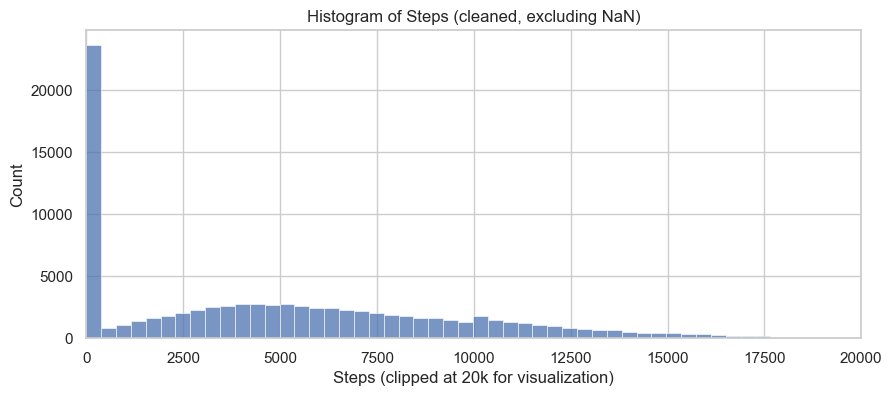

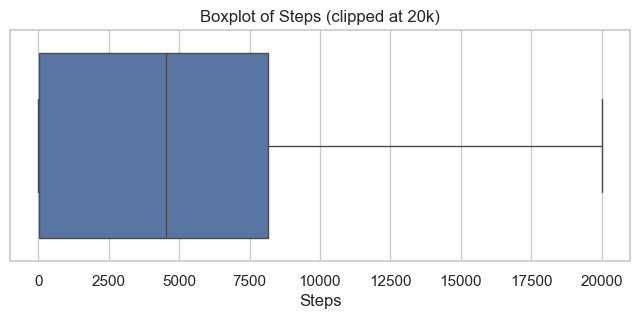

Remaining rows with Steps > 20k: 554


,Participant ID,Participant name,Group,Date,Steps,Minutessedentary,Minuteslightlyactive,Minutesfairlyactive,Minutesveryactive,Total Active Minutes (fairly + very)
342,89,user user 89,mLife (control),2022-06-16,21558.0,379,160,338,338,676
444,89,user user 89,mLife (control),2022-06-17,21877.0,710,446,233,51,284
547,89,user user 89,mLife (control),2022-06-18,20668.0,198,538,194,5,199
726,56,user user 56,mLife+Points,2022-06-20,20668.0,631,340,38,76,114
1128,35,user user 35,mLife+Points,2022-06-24,22083.0,469,285,72,89,161
...,...,...,...,...,...,...,...,...,...,...
87431,2010,user user 2010,mLife+Points2,2024-06-30,26597.0,352,223,109,102,211
87800,2016,user user 2016,mLife+Points2,2024-07-03,21097.0,983,199,56,132,188
87964,2079,user user 2079,mLife+Points2,2024-07-04,22809.0,529,250,66,90,156
88375,2145,user user 2145,mLife+Points2,2024-07-07,20865.0,573,173,5,151,156


In [19]:
# Load the cleaned dataset and inspect Steps distribution (excluding previously removed 50k+ outliers)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
# locate cleaned file - prefer existing notebook var if present
path = globals().get('cleaned_path') if 'cleaned_path' in globals() else None
if not path or not os.path.exists(path):
    path = os.path.join('..','data','cleaned','steps_no2109_cleaned.csv')
print('Loading', path)
df_clean = pd.read_csv(path)
# ensure Steps numeric and parse Date if present
df_clean['Steps'] = pd.to_numeric(df_clean.get('Steps'), errors='coerce')
if 'Date' in df_clean.columns:
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce', infer_datetime_format=True)
print('shape:', df_clean.shape)
print('Steps missing (NaN):', df_clean['Steps'].isna().sum())
s = df_clean['Steps'].dropna()
print('Steps describe (non-NaN):')
print(s.describe())
# counts above thresholds of interest
for th in [20000, 10000, 5000, 1000]:
    print(f'Count Steps > {th}:', (s > th).sum())
# Top 20 highest Steps rows (include participant and date if available)
cols = [c for c in ['Participant ID','Date','Steps'] if c in df_clean.columns]
display(df_clean.sort_values('Steps', ascending=False)[cols].head(20))
# Plot histogram and boxplot, clipping upper x for clarity
plt.figure(figsize=(10,4))
sns.histplot(s, bins=120, kde=False)
plt.title('Histogram of Steps (cleaned, excluding NaN)')
plt.xlim(0, min(s.max(), 20000))
plt.xlabel('Steps (clipped at 20k for visualization)')
plt.show()
plt.figure(figsize=(8,3))
sns.boxplot(x=s.clip(upper=20000))
plt.title('Boxplot of Steps (clipped at 20k)')
plt.show()
# show any remaining rows > 20k
remaining = df_clean[df_clean['Steps'] > 20000]
print('Remaining rows with Steps > 20k:', len(remaining))
if len(remaining):
    display(remaining)

In [20]:
# Quick text summary of cleaned Steps distribution (machine-friendly outputs)
s = df_clean['Steps'].dropna()
print('df_clean shape:', df_clean.shape)
print('Steps non-NaN count:', len(s))
print('Steps missing (NaN):', df_clean['Steps'].isna().sum())
print('\nSteps summary:')
desc = s.describe()
for k,v in desc.items():
    print(f'  {k}: {v}')
print('\nCounts above thresholds:')
for th in [20000,10000,5000,1000,0]:
    print(f'  >{th}:', (s>th).sum())
maxv = s.max() if len(s) else float('nan')
print('\nMax Steps:', maxv)
remaining = df_clean[df_clean['Steps'] > 20000]
print('Remaining rows with Steps > 20k:', len(remaining))
if len(remaining):
    # print a compact table for review
    cols = [c for c in ['Participant ID','Date','Steps','Minutessedentary','Minuteslightlyactive','Minutesfairlyactive','Minutesveryactive'] if c in df_clean.columns]
    print('\nTop remaining rows:')
    print(remaining[cols].sort_values('Steps', ascending=False).head(20).to_string(index=False))

df_clean shape: (89256, 10)
Steps non-NaN count: 89253
Steps missing (NaN): 3

Steps summary:
  count: 89253.0
  mean: 5167.317266646499
  std: 4738.542734284871
  min: 0.0
  25%: 12.0
  50%: 4523.0
  75%: 8169.0
  max: 46062.0

Counts above thresholds:
  >20000: 554
  >10000: 15022
  >5000: 41305
  >1000: 64166
  >0: 67202

Max Steps: 46062.0
Remaining rows with Steps > 20k: 554

Top remaining rows:
 Participant ID       Date   Steps  Minutessedentary  Minuteslightlyactive  Minutesfairlyactive  Minutesveryactive
            105 2022-12-13 46062.0              1204                   236                    0                  0
           2100 2023-11-05 44409.0               539                   282                   49                297
             58 2022-10-08 40586.0               345                   283                   47                297
             83 2022-10-26 40064.0               307                   223                   77                285
             62 2023-

In [21]:
# Compute minute-sum and quality flags, persist flags and updated cleaned CSV
import os
# assume df_clean is already loaded from previous cells; if not, load it
if 'df_clean' not in globals():
    path = os.path.join('..','data','cleaned','steps_no2109_cleaned.csv')
    print('Loading', path)
    df_clean = pd.read_csv(path)
# ensure numeric conversions
for c in ['Minutessedentary','Minuteslightlyactive','Minutesfairlyactive','Minutesveryactive']:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')
# compute minute sums
minute_cols = [c for c in ['Minutessedentary','Minuteslightlyactive','Minutesfairlyactive','Minutesveryactive'] if c in df_clean.columns]
df_clean['minute_sum'] = df_clean[minute_cols].sum(axis=1) if minute_cols else np.nan
# active minutes (lightly+fairly+very)
active_cols = [c for c in ['Minuteslightlyactive','Minutesfairlyactive','Minutesveryactive'] if c in df_clean.columns]
df_clean['active_minutes'] = df_clean[active_cols].sum(axis=1) if active_cols else np.nan
# steps numeric
df_clean['Steps'] = pd.to_numeric(df_clean['Steps'], errors='coerce')
# flags
df_clean['nonwear_flag'] = (df_clean['Steps'].fillna(0) == 0) & (df_clean.get('Minutessedentary',0) >= 1440)
df_clean['low_minute_coverage_flag'] = df_clean['minute_sum'] < 1200
df_clean['extreme20_flag'] = df_clean['Steps'] > 20000
# steps per minute (use total minutes if >0)
df_clean['steps_per_min'] = df_clean['Steps'] / df_clean['minute_sum'].replace({0:np.nan})
df_clean['implausible_rate_flag'] = df_clean['steps_per_min'] > 200
# counts summary
summary = {}
summary['nonwear'] = int(df_clean['nonwear_flag'].sum())
summary['low_minute_coverage'] = int(df_clean['low_minute_coverage_flag'].sum())
summary['extreme20'] = int(df_clean['extreme20_flag'].sum())
summary['implausible_rate'] = int(df_clean['implausible_rate_flag'].sum())
print('Flags summary:', summary)
# persist flagged rows and updated cleaned csv
tmp_dir = os.path.join('..','data','tmp')
os.makedirs(tmp_dir, exist_ok=True)
flags_path = os.path.join(tmp_dir, 'steps_no2109_flags.csv')
df_clean.to_csv(flags_path, index=False)
print('Saved updated cleaned dataset with flags to', flags_path)
cleaned_path = os.path.join('..','data','cleaned','steps_no2109_cleaned.csv')
os.makedirs(os.path.dirname(cleaned_path), exist_ok=True)
df_clean.to_csv(cleaned_path, index=False)
print('Overwrote cleaned dataset at', cleaned_path)

Flags summary: {'nonwear': 21470, 'low_minute_coverage': 47514, 'extreme20': 554, 'implausible_rate': 0}
Saved updated cleaned dataset with flags to ..\data\tmp\steps_no2109_flags.csv
Overwrote cleaned dataset at ..\data\cleaned\steps_no2109_cleaned.csv


In [22]:
# Export flagged subsets to data/weird/steps/ and create ML-ready CSV (drop low-minute & extreme20 rows)
import os
weird_steps_dir = os.path.join('..','data','weird','steps')
os.makedirs(weird_steps_dir, exist_ok=True)
# subsets
low_min = df_clean[df_clean['low_minute_coverage_flag']]
extreme20 = df_clean[df_clean['extreme20_flag']]
low_min_path = os.path.join(weird_steps_dir, 'low_minute_coverage.csv')
extreme20_path = os.path.join(weird_steps_dir, 'extreme20.csv')
low_min.to_csv(low_min_path, index=False)
extreme20.to_csv(extreme20_path, index=False)
print('Wrote low_min rows:', len(low_min), 'to', low_min_path)
print('Wrote extreme20 rows:', len(extreme20), 'to', extreme20_path)
# create ML-ready (drop these rows)
ml_ready = df_clean[~(df_clean['low_minute_coverage_flag'] | df_clean['extreme20_flag'])].copy()
ml_ready_path = os.path.join('..','data','cleaned','steps_no2109_ml_ready.csv')
ml_ready.to_csv(ml_ready_path, index=False)
print('Wrote ML-ready dataset with rows:', len(ml_ready), 'to', ml_ready_path)

Wrote low_min rows: 47514 to ..\data\weird\steps\low_minute_coverage.csv
Wrote extreme20 rows: 554 to ..\data\weird\steps\extreme20.csv
Wrote ML-ready dataset with rows: 41640 to ..\data\cleaned\steps_no2109_ml_ready.csv


Loading ..\data\cleaned\steps_no2109_ml_ready.csv
ML-ready shape: (20170, 17)
Steps non-NaN count: 20170
Steps describe:
count    20170.000000
mean      5770.055280
std       3966.975155
min          0.000000
25%       2799.250000
50%       5086.000000
75%       8186.000000
max      19954.000000
Name: Steps, dtype: float64

Top 10 Steps rows:


C:\Users\chris\AppData\Local\Temp\ipykernel_15300\2335936463.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ml['Date'] = pd.to_datetime(ml['Date'], errors='coerce', infer_datetime_format=True)


,Participant ID,Date,Steps,minute_sum,active_minutes
9364,2111,2023-07-31,19954.0,1440,560
7598,62,2023-05-26,19926.0,1440,520
8141,45,2023-06-20,19908.0,1440,495
9933,2166,2023-08-21,19866.0,1440,510
18384,2005,2024-05-12,19861.0,1440,315
4357,22,2022-12-24,19858.0,1276,414
4330,22,2022-12-23,19849.0,1440,411
3342,77,2022-11-08,19832.0,1220,841
10717,2066,2023-09-18,19829.0,1333,724
8549,77,2023-07-01,19767.0,1440,579



Top 10 participants by row count:
Participant ID
2122    349
2108    348
13      344
12      330
2136    326
2003    325
2148    313
2160    304
73      304
76      296


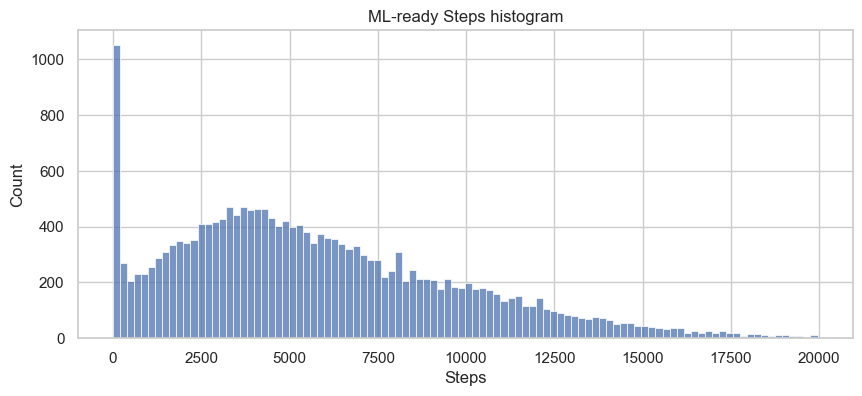

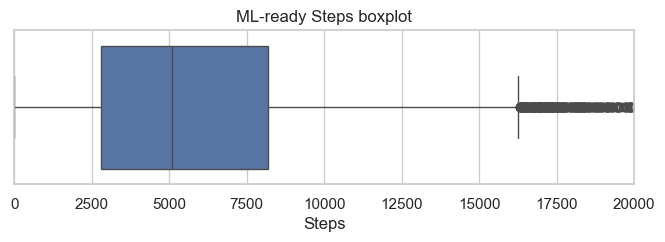


Max Steps in ML-ready: 19954.0
Rows with Steps > 10000: 3192
Rows with Steps == 0: 116


In [34]:
# Inspect the ML-ready dataset (steps_no2109_ml_ready.csv)
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
ml_path = globals().get('ml_ready_path') if 'ml_ready_path' in globals() else os.path.join('..','data','cleaned','steps_no2109_ml_ready.csv')
print('Loading', ml_path)
ml = pd.read_csv(ml_path)
# ensure numeric and date
ml['Steps'] = pd.to_numeric(ml.get('Steps'), errors='coerce')
if 'Date' in ml.columns:
    ml['Date'] = pd.to_datetime(ml['Date'], errors='coerce', infer_datetime_format=True)
print('ML-ready shape:', ml.shape)
s = ml['Steps'].dropna()
print('Steps non-NaN count:', len(s))
print('Steps describe:')
print(s.describe())
# top 10 rows
cols = [c for c in ['Participant ID','Date','Steps','minute_sum','active_minutes'] if c in ml.columns]
print('\nTop 10 Steps rows:')
display(ml.sort_values('Steps', ascending=False)[cols].head(10))
# per-participant counts
if 'Participant ID' in ml.columns:
    pc = ml['Participant ID'].value_counts().head(10)
    print('\nTop 10 participants by row count:')
    print(pc.to_string())
# plots
plt.figure(figsize=(10,4))
sns.histplot(s, bins=100)
plt.title('ML-ready Steps histogram')
plt.show()
plt.figure(figsize=(8,2))
sns.boxplot(x=s)
plt.title('ML-ready Steps boxplot')
plt.xlim(0,20000)
plt.show()
# basic checks
print('\nMax Steps in ML-ready:', s.max())
print('Rows with Steps > 10000:', (s>10000).sum())
print('Rows with Steps == 0:', (s==0).sum())

In [28]:
# Compact ML-ready text summary (machine-friendly)
s = ml['Steps'].dropna()
print('ML-ready shape:', ml.shape)
print('Steps non-NaN count:', int(s.count()))
desc = s.describe()
print('mean:', float(desc['mean']))
print('std:', float(desc['std']))
print('min:', float(desc['min']))
print('25%:', float(desc['25%']))
print('50%:', float(desc['50%']))
print('75%:', float(desc['75%']))
print('max:', float(desc['max']))
print('>10000:', int((s>10000).sum()))
print('==0:', int((s==0).sum()))
if 'Participant ID' in ml.columns:
    top_p = ml['Participant ID'].value_counts().head(5)
    print('\nTop 5 participants by rows:')
    for pid, cnt in top_p.items():
        print(pid, cnt)

ML-ready shape: (20170, 17)
Steps non-NaN count: 20170
mean: 5770.055280118989
std: 3966.975154598998
min: 0.0
25%: 2799.25
50%: 5086.0
75%: 8186.0
max: 19954.0
>10000: 3192
==0: 116

Top 5 participants by rows:
2122 349
2108 348
13 344
12 330
2136 326


In [27]:
# Extract and drop full-sedentary non-wear rows (Steps==0 & Minutessedentary==1440) from ML-ready dataset
import os
weird_steps_dir = os.path.join('..','data','weird','steps')
os.makedirs(weird_steps_dir, exist_ok=True)
# ensure numeric columns
ml['Steps'] = pd.to_numeric(ml['Steps'], errors='coerce')
ml['Minutessedentary'] = pd.to_numeric(ml.get('Minutessedentary', 0), errors='coerce')
mask_nonwear_full = (ml['Steps']==0) & (ml['Minutessedentary']==1440)
nonwear_full = ml[mask_nonwear_full].copy()
out_path = os.path.join(weird_steps_dir, 'nonwear_full_sedentary.csv')
nonwear_full.to_csv(out_path, index=False)
print('Saved nonwear_full_sedentary rows:', len(nonwear_full), 'to', out_path)
# drop them from ml and save updated ML-ready CSV
ml2 = ml[~mask_nonwear_full].copy()
ml2_path = os.path.join('..','data','cleaned','steps_no2109_ml_ready.csv')
ml2.to_csv(ml2_path, index=False)
print('Saved updated ML-ready dataset with rows:', len(ml2), 'to', ml2_path)
# update kernel variable
ml = ml2

Saved nonwear_full_sedentary rows: 21470 to ..\data\weird\steps\nonwear_full_sedentary.csv
Saved updated ML-ready dataset with rows: 20170 to ..\data\cleaned\steps_no2109_ml_ready.csv


In [29]:
# Version ML-ready CSV and write a small QA report into data/weird/steps/
import os
from datetime import datetime
weird_steps_dir = os.path.join('..','data','weird','steps')
os.makedirs(weird_steps_dir, exist_ok=True)
# find next version for ml_ready file
base = os.path.join('..','data','cleaned','steps_no2109_ml_ready')
i = 1
while True:
    candidate = f"{base}_v{i}.csv"
    if not os.path.exists(candidate):
        break
    i += 1
versioned_path = candidate
# save versioned copy
import shutil
shutil.copyfile(os.path.join('..','data','cleaned','steps_no2109_ml_ready.csv'), versioned_path)
print('Saved versioned ML-ready CSV to', versioned_path)
# create QA summary
qa = {}
qa['ml_ready_rows'] = len(ml)
qa['low_min_rows'] = len(low_min)
qa['extreme20_rows'] = len(extreme20)
qa['nonwear_full_rows'] = len(nonwear_full)
qa['date'] = datetime.utcnow().isoformat()
# write QA csv and markdown
qa_df = pd.DataFrame([qa])
qa_csv = os.path.join(weird_steps_dir, 'qa_summary_steps_ml_ready.csv')
qa_md = os.path.join(weird_steps_dir, 'qa_summary_steps_ml_ready.md')
qa_df.to_csv(qa_csv, index=False)
with open(qa_md, 'w', encoding='utf8') as f:
    f.write('# QA summary for steps ML-ready dataset\n')
    f.write(f"Date (UTC): {qa['date']}\n\n")
    f.write(f"ML-ready rows: {qa['ml_ready_rows']}\n")
    f.write(f"Low-minute rows archived: {qa['low_min_rows']}\n")
    f.write(f"Extreme>20k rows archived: {qa['extreme20_rows']}\n")
    f.write(f"Non-wear full sedentary rows archived: {qa['nonwear_full_rows']}\n")
print('Wrote QA files to', weird_steps_dir)

Saved versioned ML-ready CSV to ..\data\cleaned\steps_no2109_ml_ready_v1.csv
Wrote QA files to ..\data\weird\steps


C:\Users\chris\AppData\Local\Temp\ipykernel_15300\1010781339.py:25: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  qa['date'] = datetime.utcnow().isoformat()


In [ ]:
# Analyze low_minute_coverage archive and produce per-participant summary
import pandas as pd
from pathlib import Path

low_min_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage.csv")
out_summary = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage_participant_summary.csv")

print('Loading', low_min_path)
df_low = pd.read_csv(low_min_path, parse_dates=['Date'])
print('rows_in_archive:', len(df_low))

# Describe minute_sum distribution
print('\nminute_sum describe:')
print(df_low['minute_sum'].describe())

# Candidate thresholds
thresholds = [900,1000,1100,1200,1300,1400,1440]
overall = []
for t in thresholds:
    # row count below threshold
    c = int((df_low['minute_sum'] < t).sum())
    # number of unique participants affected
    p = int(df_low.loc[df_low['minute_sum'] < t, 'Participant ID'].nunique())
    overall.append({'threshold': t, 'count': c, 'participants': p, 'pct': c/len(df_low)*100})
print('
print(pd.DataFrame(overall))

# Per-participant summary
grp = df_low.groupby('Participant ID')
rows = []
for pid, g in grp:
    s = {
        'participant_id': int(pid),
        'n_rows': len(g),
        'minute_sum_min': int(g['minute_sum'].min()),
        'minute_sum_25': float(g['minute_sum'].quantile(0.25)),
        'minute_sum_median': float(g['minute_sum'].median()),
        'minute_sum_mean': float(g['minute_sum'].mean()),
        'minute_sum_75': float(g['minute_sum'].quantile(0.75)),
        'minute_sum_max': int(g['minute_sum'].max())
    }
    for t in thresholds:
        cnt = int((g['minute_sum'] < t).sum())
        s[f'lt_{t}_count'] = cnt
        s[f'lt_{t}_pct'] = cnt/len(g)*100
    rows.append(s)

ps = pd.DataFrame(rows).sort_values('participant_id')
ps.to_csv(out_summary, index=False)
print('\nWrote participant summary to', out_summary)

# Show top participants with highest pct < 1200
ps['lt_1200_pct'] = ps['lt_1200_pct']
top = ps.sort_values('lt_1200_pct', ascending=False).head(10)
print('\nTop 10 participants by percent of their archived days below 1200 minutes:')
print(top[['participant_id','n_rows','lt_1200_count','lt_1200_pct','minute_sum_median','minute_sum_mean']])

# Small sample of the archive
print('\nSample rows:')
print(df_low.head().to_string(index=False))
print('\nDone')


print('\nDone')

Loading c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage.csv
rows_in_archive: 47514

minute_sum describe:
count    47514.000000
mean       960.034053
std        112.895166
min         38.000000
25%        903.000000
50%        969.000000
75%       1029.000000
max       1199.000000
Name: minute_sum, dtype: float64

Overall counts below thresholds:
   threshold  count         pct
0        900  11376   23.942417
1       1000  29956   63.046681
2       1100  43499   91.549859
3       1200  47514  100.000000
4       1300  47514  100.000000
5       1400  47514  100.000000
6       1440  47514  100.000000

Wrote participant summary to c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage_participant_summary.csv

Top 10 participants by percent of their archived days below 1200 minutes:
   participant_id  n_rows  lt_1200_count  lt_1200_pct  minute_sum_median  \
0               7       3              3        100.0              916.0   
1               8  

In [32]:
# Extended threshold analysis for minute_sum (e.g., 8 hours = 480 minutes)
import pandas as pd
from pathlib import Path

low_min_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage.csv")
out_overall = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage_thresholds_overall.csv")
out_part = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage_participant_summary_extended.csv")

print('Loading', low_min_path)
df_low = pd.read_csv(low_min_path, parse_dates=['Date'])
print('rows_in_archive:', len(df_low))

# Extended thresholds: 480 (8h), 600 (10h), 720 (12h), 840 (14h), 960 (16h), 1080 (18h), 1200, 1320, 1440
thresholds_ext = [480,600,720,840,960,1080,1200,1320,1440]

overall = []
for t in thresholds_ext:
    # row count below threshold
    c = int((df_low['minute_sum'] < t).sum())
    # unique participants affected
    p = int(df_low.loc[df_low['minute_sum'] < t, 'Participant ID'].nunique())
    overall.append({'threshold_min': t, 'count': c, 'participants': p, 'pct': c/len(df_low)*100})
overall_df = pd.DataFrame(overall)
overall_df.to_csv(out_overall, index=False)
print('\nWrote overall threshold counts to', out_overall)
print(overall_df)

# Per-participant extended summary
grp = df_low.groupby('Participant ID')
rows = []
for pid, g in grp:
    s = {'participant_id': int(pid), 'n_rows': len(g), 'minute_sum_median': float(g['minute_sum'].median()), 'minute_sum_mean': float(g['minute_sum'].mean())}
    for t in thresholds_ext:
        cnt = int((g['minute_sum'] < t).sum())
        s[f'lt_{t}_count'] = cnt
        s[f'lt_{t}_pct'] = cnt/len(g)*100
    rows.append(s)
ps_ext = pd.DataFrame(rows).sort_values('participant_id')
ps_ext.to_csv(out_part, index=False)
print('\nWrote per-participant extended summary to', out_part)

# show top participants with highest pct < 480
ps_ext['lt_480_pct'] = ps_ext['lt_480_pct']
print('\nTop 10 participants by percent < 480 min (8 hours):')
print(ps_ext.sort_values('lt_480_pct', ascending=False)[['participant_id','n_rows','lt_480_count','lt_480_pct','minute_sum_median']].head(10).to_string(index=False))

print('\nDone')


Loading c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage.csv
rows_in_archive: 47514

Wrote overall threshold counts to c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage_thresholds_overall.csv
   threshold_min  count  participants         pct
0            480    194            86    0.408301
1            600    475           140    0.999705
2            720   1336           186    2.811803
3            840   5470           235   11.512396
4            960  21694           241   45.658122
5           1080  41867           242   88.115082
6           1200  47514           242  100.000000
7           1320  47514           242  100.000000
8           1440  47514           242  100.000000

Wrote per-participant extended summary to c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage_participant_summary_extended.csv

Top 10 participants by percent < 480 min (8 hours):
 participant_id  n_rows  lt_480_count  lt_480_pct  minute_sum_

In [35]:
# New cell: Compact ML-ready dataset summary
import os
from pathlib import Path
import pandas as pd
import numpy as np

ml_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\cleaned\steps_no2109_ml_ready.csv")
print('Loading', ml_path)
df_ml = pd.read_csv(ml_path)
# parse Date if present
if 'Date' in df_ml.columns:
    df_ml['Date'] = pd.to_datetime(df_ml['Date'], errors='coerce', infer_datetime_format=True)
# ensure Steps numeric
df_ml['Steps'] = pd.to_numeric(df_ml.get('Steps'), errors='coerce')

print('\nBasic counts:')
print('  rows:', len(df_ml))
print('  unique participants:', int(df_ml['Participant ID'].nunique()) if 'Participant ID' in df_ml.columns else 'N/A')

# Steps stats
s = df_ml['Steps']
print('\nSteps (non-NaN) count:', int(s.count()))
print(s.describe())

# Counts above thresholds
for th in [10000,5000,1000,0]:
    print(f"Count Steps > {th}:", int((s > th).sum()))

# Top 10 rows by Steps
cols = [c for c in ['Participant ID','Date','Steps','minute_sum','active_minutes'] if c in df_ml.columns]
print('\nTop 10 rows by Steps:')
print(df_ml.sort_values('Steps', ascending=False)[cols].head(10).to_string(index=False))

# Top participants by number of rows
if 'Participant ID' in df_ml.columns:
    pc = df_ml['Participant ID'].value_counts().head(10)
    print('\nTop 10 participants by row count:')
    print(pc.to_string())

# Save a small summary CSV
summary = {
    'rows': len(df_ml),
    'participants': int(df_ml['Participant ID'].nunique()) if 'Participant ID' in df_ml.columns else None,
    'steps_non_na': int(s.count()),
    'steps_max': float(s.max()) if s.count() else None,
    'steps_mean': float(s.mean()) if s.count() else None
}

out_dir = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / 'ml_ready_dataset_summary.csv'
pd.DataFrame([summary]).to_csv(out_path, index=False)
print('\nWrote summary to', out_path)

Loading c:\Users\chris\Documents\lab\mlife\data\cleaned\steps_no2109_ml_ready.csv

Basic counts:
  rows: 20170
  unique participants: 236

Steps (non-NaN) count: 20170
count    20170.000000
mean      5770.055280
std       3966.975155
min          0.000000
25%       2799.250000
50%       5086.000000
75%       8186.000000
max      19954.000000
Name: Steps, dtype: float64
Count Steps > 10000: 3192
Count Steps > 5000: 10253
Count Steps > 1000: 18180
Count Steps > 0: 20054

Top 10 rows by Steps:
 Participant ID       Date   Steps  minute_sum  active_minutes
           2111 2023-07-31 19954.0        1440             560
             62 2023-05-26 19926.0        1440             520
             45 2023-06-20 19908.0        1440             495
           2166 2023-08-21 19866.0        1440             510
           2005 2024-05-12 19861.0        1440             315
             22 2022-12-24 19858.0        1276             414
             22 2022-12-23 19849.0        1440             411


C:\Users\chris\AppData\Local\Temp\ipykernel_15300\3771837607.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_ml['Date'] = pd.to_datetime(df_ml['Date'], errors='coerce', infer_datetime_format=True)


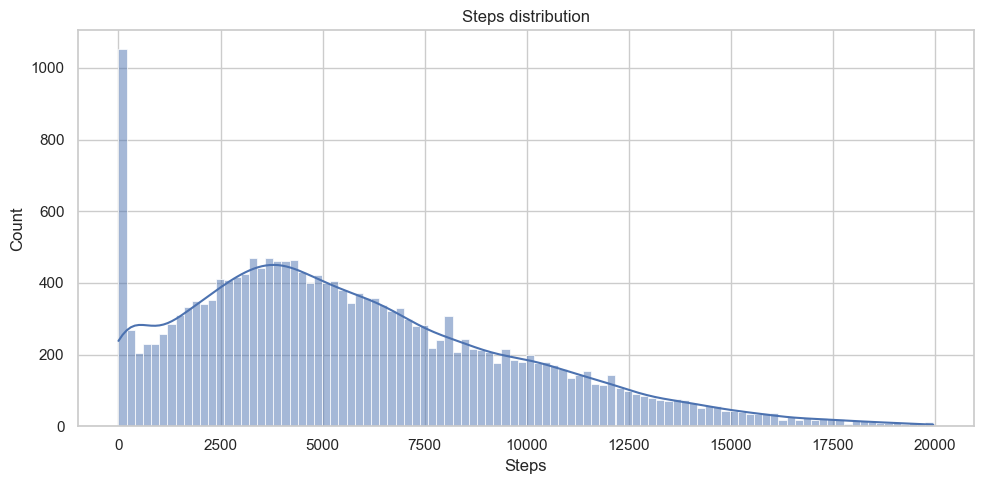

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\steps_hist_kde.png


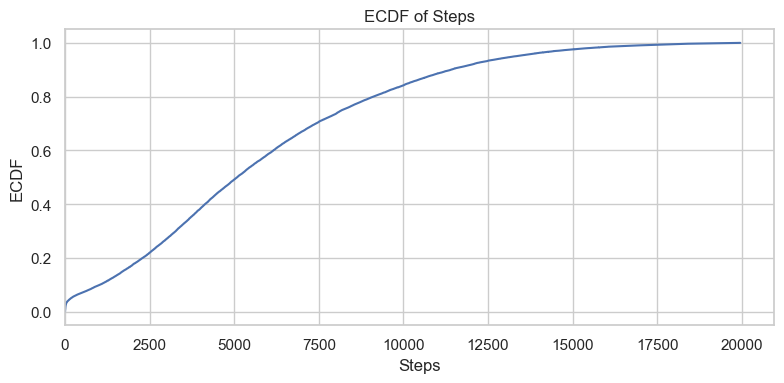

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\steps_ecdf.png


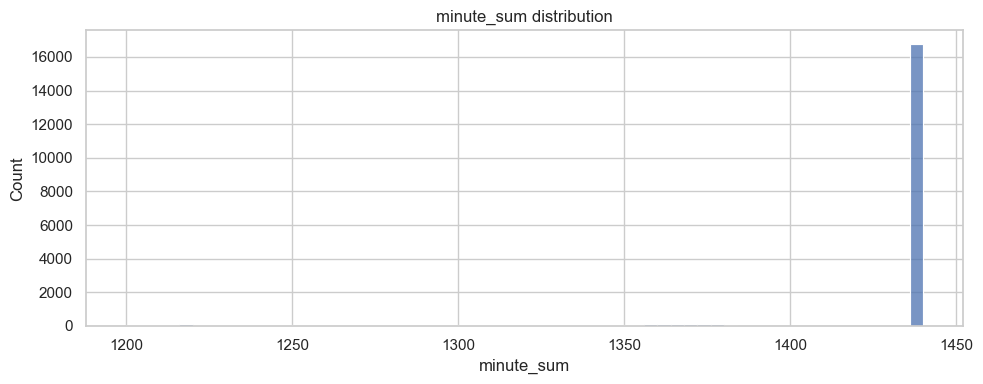

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\minute_sum_hist.png


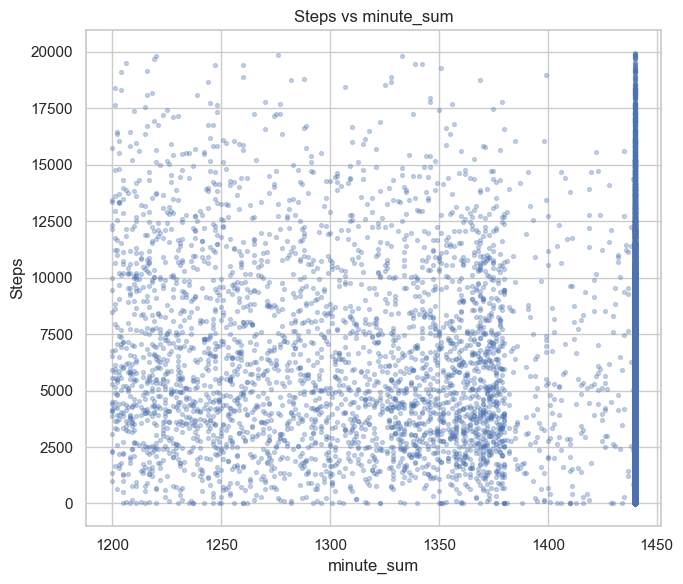

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\steps_vs_minute_sum.png


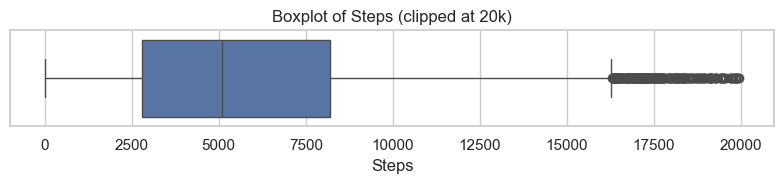

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\steps_boxplot.png
Wrote percentiles CSV to c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\percentiles_steps_minute_sum.csv


In [38]:
# New cell: Diagnostic plots for ML-ready dataset
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

ml_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\cleaned\steps_no2109_ml_ready.csv")
df_ml = pd.read_csv(ml_path)
# ensure numeric and parse Date
if 'Date' in df_ml.columns:
    df_ml['Date'] = pd.to_datetime(df_ml['Date'], errors='coerce')
df_ml['Steps'] = pd.to_numeric(df_ml.get('Steps'), errors='coerce')
if 'minute_sum' in df_ml.columns:
    df_ml['minute_sum'] = pd.to_numeric(df_ml['minute_sum'], errors='coerce')

out_dir = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots")
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Steps histogram + KDE (log x for clarity optional)
plt.figure(figsize=(10,5))
sns.histplot(df_ml['Steps'].dropna(), bins=100, kde=True)
plt.title('Steps distribution')
plt.xlabel('Steps')
plt.tight_layout()
fn = out_dir / 'steps_hist_kde.png'
plt.savefig(fn, dpi=150)
plt.show()
print('Wrote', fn)

# 2) ECDF of Steps (empirical CDF)
plt.figure(figsize=(8,4))
steps = df_ml['Steps'].dropna().sort_values()
y = np.arange(1, len(steps)+1) / len(steps)
plt.plot(steps, y)
plt.xlim(0, min(22000, steps.max()*1.05))
plt.xlabel('Steps')
plt.ylabel('ECDF')
plt.title('ECDF of Steps')
plt.tight_layout()
fn = out_dir / 'steps_ecdf.png'
plt.savefig(fn, dpi=150)
plt.show()
print('Wrote', fn)

# 3) minute_sum distribution (if present)
if 'minute_sum' in df_ml.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df_ml['minute_sum'].dropna(), bins=60)
    plt.title('minute_sum distribution')
    plt.xlabel('minute_sum')
    plt.tight_layout()
    fn = out_dir / 'minute_sum_hist.png'
    plt.savefig(fn, dpi=150)
    plt.show()
    print('Wrote', fn)

# 4) Scatter: Steps vs minute_sum (alpha for density)
if 'minute_sum' in df_ml.columns:
    plt.figure(figsize=(7,6))
    plt.scatter(df_ml['minute_sum'], df_ml['Steps'], alpha=0.3, s=8)
    plt.xlabel('minute_sum')
    plt.ylabel('Steps')
    plt.title('Steps vs minute_sum')
    plt.tight_layout()
    fn = out_dir / 'steps_vs_minute_sum.png'
    plt.savefig(fn, dpi=150)
    plt.show()
    print('Wrote', fn)

# 5) Boxplot of Steps (clipped at 20000 for clarity)
plt.figure(figsize=(8,2))
sns.boxplot(x=df_ml['Steps'].clip(upper=20000))
plt.title('Boxplot of Steps (clipped at 20k)')
plt.tight_layout()
fn = out_dir / 'steps_boxplot.png'
plt.savefig(fn, dpi=150)
plt.show()
print('Wrote', fn)

# 6) Percentiles CSV for Steps and minute_sum
percentiles = [0,1,5,10,25,50,75,90,95,99,100]
ps = np.percentile(df_ml['Steps'].dropna(), percentiles)
summary = {'metric': [], 'percentile': [], 'value': []}
for p, val in zip(percentiles, ps):
    summary['metric'].append('Steps')
    summary['percentile'].append(p)
    summary['value'].append(float(val))
if 'minute_sum' in df_ml.columns:
    ms_ps = np.percentile(df_ml['minute_sum'].dropna(), percentiles)
    for p, val in zip(percentiles, ms_ps):
        summary['metric'].append('minute_sum')
        summary['percentile'].append(p)
        summary['value'].append(float(val))

pd.DataFrame(summary).to_csv(out_dir / 'percentiles_steps_minute_sum.csv', index=False)
print('Wrote percentiles CSV to', out_dir / 'percentiles_steps_minute_sum.csv')

In [39]:
# New cell: Per-participant ML-ready summary
from pathlib import Path
import pandas as pd
import numpy as np

ml_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\cleaned\steps_no2109_ml_ready.csv")
df = pd.read_csv(ml_path)
# parse date
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# numeric conversions
df['Steps'] = pd.to_numeric(df.get('Steps'), errors='coerce')
if 'minute_sum' in df.columns:
    df['minute_sum'] = pd.to_numeric(df['minute_sum'], errors='coerce')

out_dir = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / 'per_participant_summary_ml_ready.csv'

rows = []
for pid, g in df.groupby('Participant ID'):
    s = {}
    s['participant_id'] = pid
    s['n_rows'] = len(g)
    s['steps_mean'] = float(g['Steps'].mean()) if g['Steps'].notna().any() else None
    s['steps_median'] = float(g['Steps'].median()) if g['Steps'].notna().any() else None
    s['steps_std'] = float(g['Steps'].std()) if g['Steps'].notna().any() else None
    s['steps_pct_zero'] = float((g['Steps']==0).sum()) / len(g) * 100
    if 'Date' in g.columns:
        s['date_min'] = g['Date'].min()
        s['date_max'] = g['Date'].max()
        s['date_span_days'] = (s['date_max'] - s['date_min']).days
    else:
        s['date_min'] = None
        s['date_max'] = None
        s['date_span_days'] = None
    if 'minute_sum' in g.columns:
        s['minute_sum_mean'] = float(g['minute_sum'].mean())
        s['minute_sum_median'] = float(g['minute_sum'].median())
        s['minute_sum_min'] = float(g['minute_sum'].min())
        s['minute_sum_max'] = float(g['minute_sum'].max())
    rows.append(s)

pp = pd.DataFrame(rows).sort_values('n_rows', ascending=False)
pp.to_csv(out_path, index=False)
print('Wrote per-participant summary to', out_path)

# show top and bottom participants by row count
print('\nTop 10 participants by row count:')
print(pp[['participant_id','n_rows','steps_mean','steps_median','steps_pct_zero']].head(10).to_string(index=False))
print('\nBottom 10 participants by row count:')
print(pp[['participant_id','n_rows','steps_mean','steps_median','steps_pct_zero']].tail(10).to_string(index=False))

Wrote per-participant summary to c:\Users\chris\Documents\lab\mlife\data\weird\steps\per_participant_summary_ml_ready.csv

Top 10 participants by row count:
 participant_id  n_rows  steps_mean  steps_median  steps_pct_zero
           2122     349 6334.578797        5855.0        0.000000
           2108     348 5204.140805        4212.0        0.000000
             13     344 4422.924419        4174.5        0.000000
             12     330 7314.463636        7109.5        0.000000
           2136     326 4729.536810        4900.0        0.000000
           2003     325 7410.470769        7340.0        0.000000
           2148     313 2036.252396        1990.0        0.958466
           2160     304 3753.493421        3932.5        0.328947
             73     304 6688.496711        6501.5        0.000000
             76     296 3387.530405        3323.5        0.000000

Bottom 10 participants by row count:
 participant_id  n_rows  steps_mean  steps_median  steps_pct_zero
           20

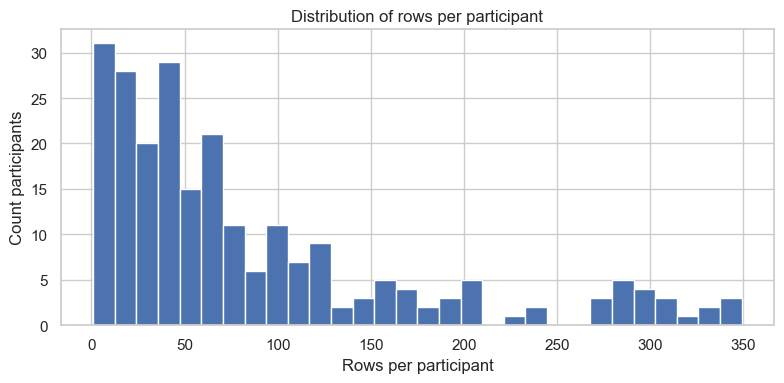

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\per_participant_rowcount_hist.png


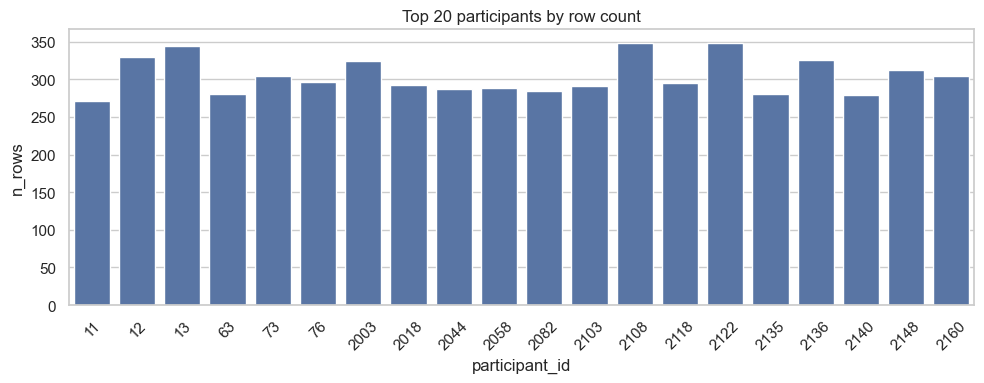

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\top20_participants_rowcount.png
Wrote participants with <30 rows to c:\Users\chris\Documents\lab\mlife\data\weird\steps\participants_lt_30_rows.csv

Sample of participants with <30 rows:
 participant_id  n_rows  steps_mean  steps_median   steps_std  steps_pct_zero   date_min   date_max  date_span_days  minute_sum_mean  minute_sum_median  minute_sum_min  minute_sum_max
           2065       1        42.0          42.0         NaN             0.0 2023-06-28 2023-06-28               0           1440.0             1440.0          1440.0          1440.0
           2011       1      3055.0        3055.0         NaN             0.0 2023-11-22 2023-11-22               0           1278.0             1278.0          1278.0          1278.0
           2076       1      3985.0        3985.0         NaN             0.0 2023-08-20 2023-08-20               0           1219.0             1219.0          1219.0          1219.0
           21

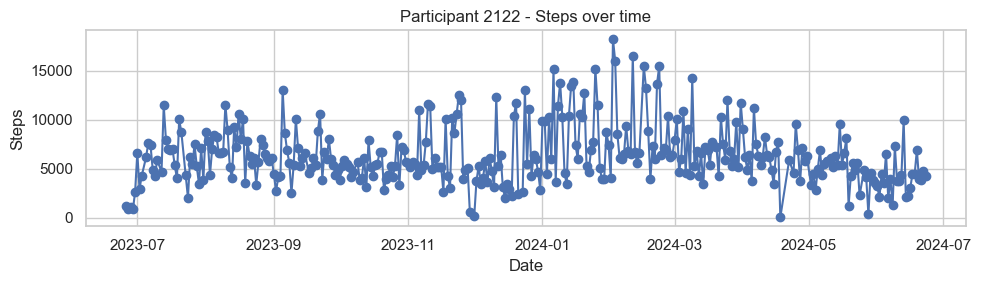

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\participant_2122_timeseries.png


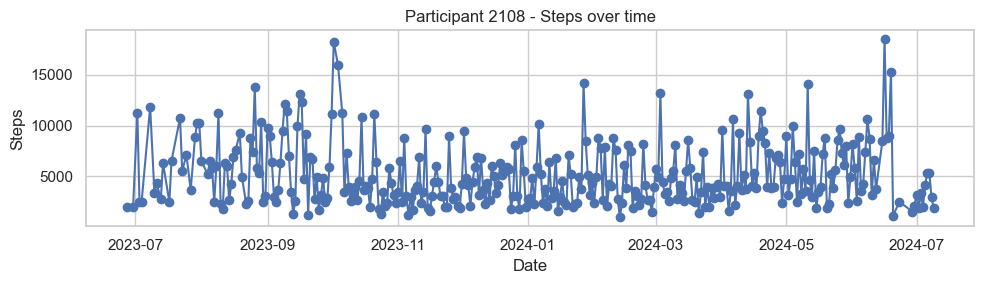

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\participant_2108_timeseries.png


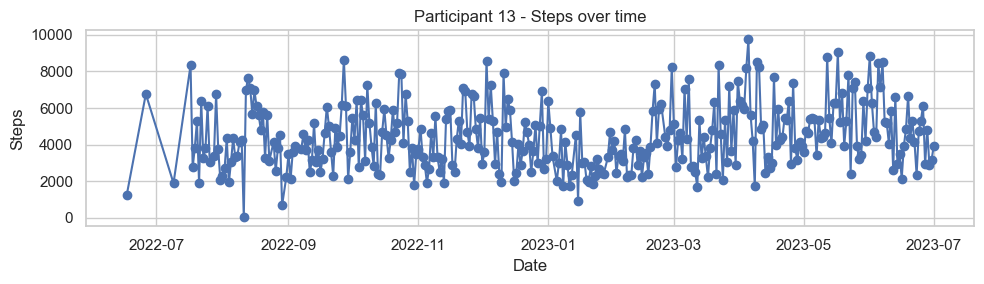

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\participant_13_timeseries.png


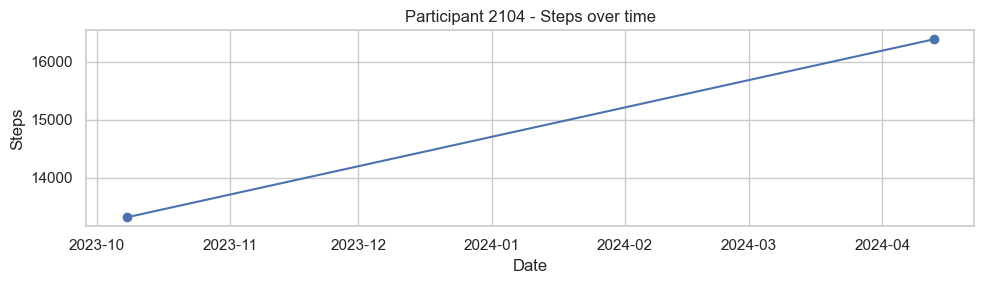

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\participant_2104_timeseries.png


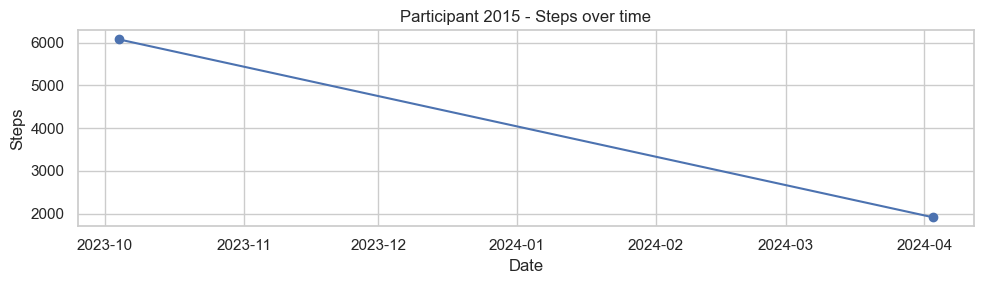

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\participant_2015_timeseries.png


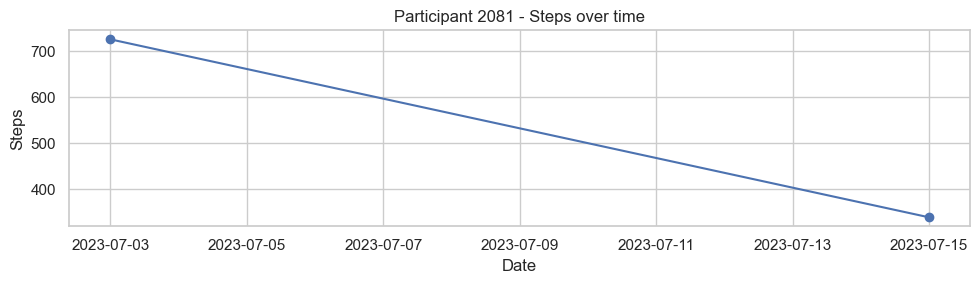

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\participant_2081_timeseries.png

Done


In [42]:
# New cell: Per-participant plots and small-count table
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

ml_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\cleaned\steps_no2109_ml_ready.csv")
pp_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\per_participant_summary_ml_ready.csv")
plots_dir = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots")
plots_dir.mkdir(parents=True, exist_ok=True)

# load per-participant summary and ml data
pp = pd.read_csv(pp_path)
df = pd.read_csv(ml_path)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 1) Histogram of per-participant row counts
plt.figure(figsize=(8,4))
plt.hist(pp['n_rows'], bins=30)
plt.xlabel('Rows per participant')
plt.ylabel('Count participants')
plt.title('Distribution of rows per participant')
fn = plots_dir / 'per_participant_rowcount_hist.png'
plt.tight_layout()
plt.savefig(fn, dpi=150)
plt.show()
print('Wrote', fn)

# 2) Bar chart top 20 participants by rows
top20 = pp.sort_values('n_rows', ascending=False).head(20)
plt.figure(figsize=(10,4))
sns.barplot(x='participant_id', y='n_rows', data=top20)
plt.xticks(rotation=45)
plt.title('Top 20 participants by row count')
fn = plots_dir / 'top20_participants_rowcount.png'
plt.tight_layout()
plt.savefig(fn, dpi=150)
plt.show()
print('Wrote', fn)

# 3) Participants with <30 rows
small = pp[pp['n_rows'] < 30].sort_values('n_rows')
small_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\participants_lt_30_rows.csv")
small.to_csv(small_path, index=False)
print('Wrote participants with <30 rows to', small_path)
print('\nSample of participants with <30 rows:')
print(small.head(10).to_string(index=False))

# 4) Time-series sample plots for top 3 and bottom 3 (with >1 row)
top3_ids = pp.sort_values('n_rows', ascending=False).head(3)['participant_id'].tolist()
bottom_candidates = pp[pp['n_rows']>1].sort_values('n_rows', ascending=True).head(10)
bottom3_ids = bottom_candidates.head(3)['participant_id'].tolist()

sample_ids = top3_ids + bottom3_ids
print('\nPlotting sample time-series for participants:', sample_ids)
for pid in sample_ids:
    g = df[df['Participant ID'] == pid].sort_values('Date')
    if g.empty or 'Date' not in g.columns:
        continue
    plt.figure(figsize=(10,3))
    plt.plot(g['Date'], g['Steps'], marker='o', linestyle='-')
    plt.title(f'Participant {pid} - Steps over time')
    plt.xlabel('Date')
    plt.ylabel('Steps')
    fn = plots_dir / f'participant_{pid}_timeseries.png'
    plt.tight_layout()
    plt.savefig(fn, dpi=150)
    plt.show()
    print('Wrote', fn)

print('\nDone')

Wrote retention CSV to c:\Users\chris\Documents\lab\mlife\data\weird\steps\per_participant_retention.csv


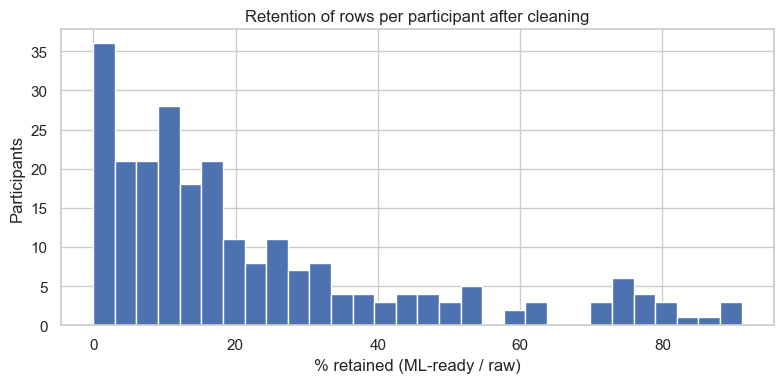

Wrote c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots\per_participant_retention_hist.png

Retention summary:
count    243.000000
mean      22.487917
std       22.516914
min        0.000000
25%        7.060158
50%       14.678899
75%       30.101051
max       91.122715

Participants with 0% retained (count): 7
Wrote participants with zero retention to c:\Users\chris\Documents\lab\mlife\data\weird\steps\participants_zero_retention.csv


In [41]:
# New cell: compute per-participant retention (raw -> ML-ready)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

raw_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\raw\steps.csv")
ml_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\cleaned\steps_no2109_ml_ready.csv")
pp_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\per_participant_summary_ml_ready.csv")
plots_dir = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\plots")
plots_dir.mkdir(parents=True, exist_ok=True)

raw = pd.read_csv(raw_path)
raw_counts = raw.groupby('Participant ID').size().reset_index(name='raw_n')
pp = pd.read_csv(pp_path)
pp = pp.rename(columns={'participant_id':'Participant ID', 'n_rows':'ml_n'})

merged = raw_counts.merge(pp[['Participant ID','ml_n']], on='Participant ID', how='left')
merged['ml_n'] = merged['ml_n'].fillna(0).astype(int)
merged['pct_retained'] = (merged['ml_n'] / merged['raw_n']) * 100.0

out_csv = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\per_participant_retention.csv")
merged.to_csv(out_csv, index=False)
print('Wrote retention CSV to', out_csv)

# histogram of percent retained
plt.figure(figsize=(8,4))
plt.hist(merged['pct_retained'].dropna(), bins=30)
plt.xlabel('% retained (ML-ready / raw)')
plt.ylabel('Participants')
plt.title('Retention of rows per participant after cleaning')
fn = plots_dir / 'per_participant_retention_hist.png'
plt.tight_layout()
plt.savefig(fn, dpi=150)
plt.show()
print('Wrote', fn)

# quick summary print
print('\nRetention summary:')
print(merged['pct_retained'].describe().to_string())

# participants with 0% retained
zero_ret = merged[merged['pct_retained']==0]
print('\nParticipants with 0% retained (count):', len(zero_ret))

# save list of participants with 0% retained
zero_csv = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\participants_zero_retention.csv")
zero_ret.to_csv(zero_csv, index=False)
print('Wrote participants with zero retention to', zero_csv)

In [43]:
# New cell: create ML-ready_plus_840 dataset — add back low_minute_coverage rows with minute_sum > 840
from pathlib import Path
import pandas as pd

ml_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\cleaned\steps_no2109_ml_ready.csv")
low_min_path = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps\low_minute_coverage.csv")
out_dir = Path(r"c:\Users\chris\Documents\lab\mlife\data\cleaned")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / 'steps_no2109_ml_ready_plus_840.csv'
summary_dir = Path(r"c:\Users\chris\Documents\lab\mlife\data\weird\steps")
summary_dir.mkdir(parents=True, exist_ok=True)

# load existing ML-ready
df_ml = pd.read_csv(ml_path, parse_dates=['Date'])
# load low-minute archive
df_low = pd.read_csv(low_min_path, parse_dates=['Date'])

# ensure minute_sum numeric
if 'minute_sum' not in df_low.columns:
    # attempt to compute from minute columns if present
    minute_cols = [c for c in df_low.columns if 'minute' in c.lower() and 'total' not in c.lower()]
    if minute_cols:
        df_low['minute_sum'] = df_low[minute_cols].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    else:
        df_low['minute_sum'] = pd.to_numeric(df_low.get('minute_sum'), errors='coerce')
else:
    df_low['minute_sum'] = pd.to_numeric(df_low['minute_sum'], errors='coerce')

# select rows with minute_sum > 840 to add back
add_back = df_low[df_low['minute_sum'] > 840].copy()
print('Rows in low_min archive:', len(df_low))
print('Rows with minute_sum > 840 to add back:', len(add_back))

# Avoid duplicates: only add rows that are not already in df_ml.
# Define a key — Participant ID + Date + Steps (if present)
key_cols = ['Participant ID', 'Date']
if 'Steps' in df_ml.columns and 'Steps' in add_back.columns:
    key_cols.append('Steps')

# normalize Date type for merge
for d in ('Date',):
    if d in add_back.columns:
        add_back[d] = pd.to_datetime(add_back[d], errors='coerce')

existing_keys = df_ml[key_cols].drop_duplicates()
add_keys = add_back[key_cols].drop_duplicates()
# inner merge to find intersection
merged_keys = add_keys.merge(existing_keys, on=key_cols, how='left', indicator=True)
already_present = merged_keys[merged_keys['_merge']=='both']
print('Rows to add that are already present (by key):', len(already_present))

# keep only new rows
if len(already_present):
    # create a boolean mask to filter duplicates
    merged_keys['_keep'] = merged_keys['_merge'] != 'both'
    keep_keys = merged_keys[merged_keys['_keep']][key_cols]
    add_back = add_back.merge(keep_keys, on=key_cols, how='inner')

# concat and write
df_plus = pd.concat([df_ml, add_back], ignore_index=True, sort=False)
df_plus.to_csv(out_path, index=False)
print('Wrote new ML-ready_plus_840 to', out_path, 'rows=', len(df_plus))

# write a small summary CSV showing counts added by participant
if len(add_back):
    added_by_part = add_back.groupby('Participant ID').size().reset_index(name='added_rows')
else:
    added_by_part = pd.DataFrame(columns=['Participant ID','added_rows'])

# write per-participant delta
delta_out = summary_dir / 'per_participant_added_plus_840.csv'
added_by_part.to_csv(delta_out, index=False)
print('Wrote per-participant added counts to', delta_out)

# write overall summary
summary = {
    'ml_ready_rows_original': int(len(df_ml)),
    'rows_added_from_low_min_over_840': int(len(add_back)),
    'ml_ready_plus_840_rows': int(len(df_plus)),
}
summary_out = summary_dir / 'ml_ready_plus_840_summary.csv'
pd.DataFrame([summary]).to_csv(summary_out, index=False)
print('Wrote overall summary to', summary_out)

# quick top participants added
print('\nTop participants added (by added_rows):')
print(added_by_part.sort_values('added_rows', ascending=False).head(10).to_string(index=False))

print('\nDone')

Rows in low_min archive: 47514
Rows with minute_sum > 840 to add back: 41976
Rows to add that are already present (by key): 0
Wrote new ML-ready_plus_840 to c:\Users\chris\Documents\lab\mlife\data\cleaned\steps_no2109_ml_ready_plus_840.csv rows= 62146
Wrote per-participant added counts to c:\Users\chris\Documents\lab\mlife\data\weird\steps\per_participant_added_plus_840.csv
Wrote overall summary to c:\Users\chris\Documents\lab\mlife\data\weird\steps\ml_ready_plus_840_summary.csv

Top participants added (by added_rows):
 Participant ID  added_rows
             54         393
             33         386
             37         379
           2033         377
           2104         374
           2015         370
           2128         367
           2004         363
           2112         363
           2076         362

Done


Loading datasets...

Overall summary:


,dataset,rows,participants,steps_non_na,steps_mean,steps_median,steps_max,pct_rows_minute_sum_1440
0,ml_ready,20170,236,20170,5770.055280,5086.0,19954.0,82.915221
1,ml_ready_plus_840,62146,238,62143,6887.013662,6223.0,44409.0,26.910823



Percentiles (Steps and minute_sum):


dataset                ml_ready  ml_ready_plus_840
percentile metric                                 
0          Steps           0.00                0.0
           minute_sum   1200.00              841.0
1          Steps           7.00                8.0
           minute_sum   1210.00              848.0
5          Steps         171.90              974.0
           minute_sum   1257.00              877.0
10         Steps        1026.00             1961.2
           minute_sum   1331.00              902.0
25         Steps        2799.25             3770.0
           minute_sum   1440.00              956.0
50         Steps        5086.00             6223.0
           minute_sum   1440.00             1035.0
75         Steps        8186.00             9560.0
           minute_sum   1440.00             1440.0
90         Steps       11403.00            12534.8
           minute_sum   1440.00             1440.0
95         Steps       13300.55            14568.8
           minute_sum   1440.00             1440.0
99         Steps       16881.31            18995.9
           minute_sum   1440.00             1440.0
100        Steps       19954.00            44409.0
           minute_sum   1440.00             1440.0

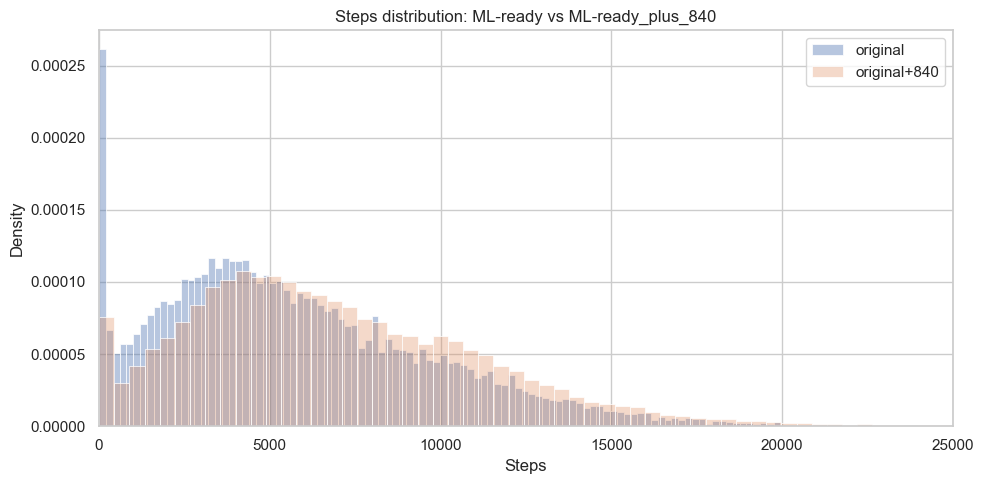

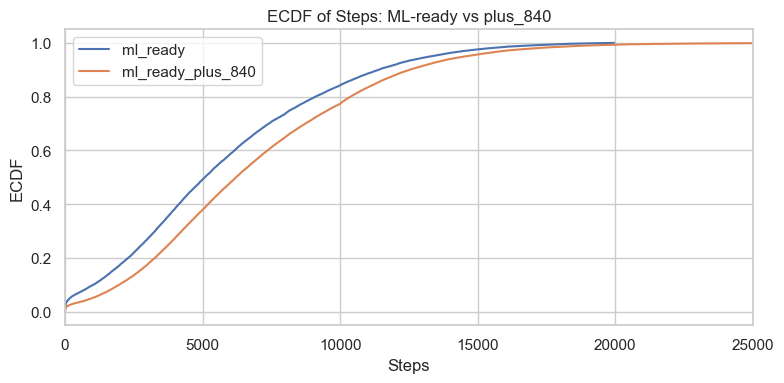

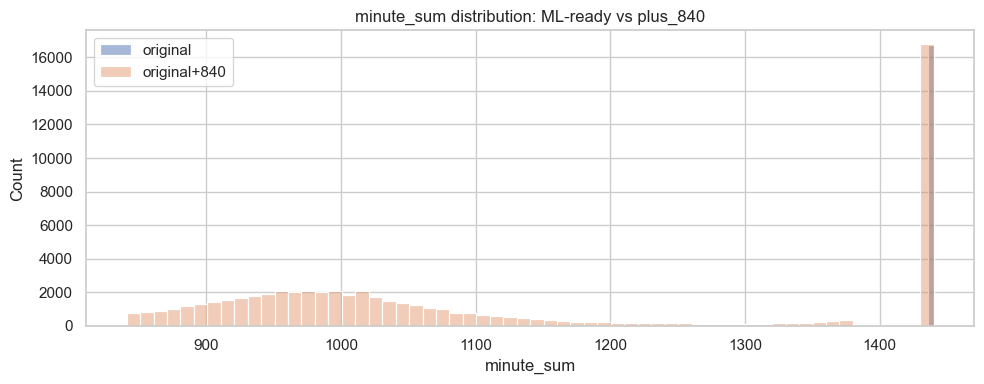

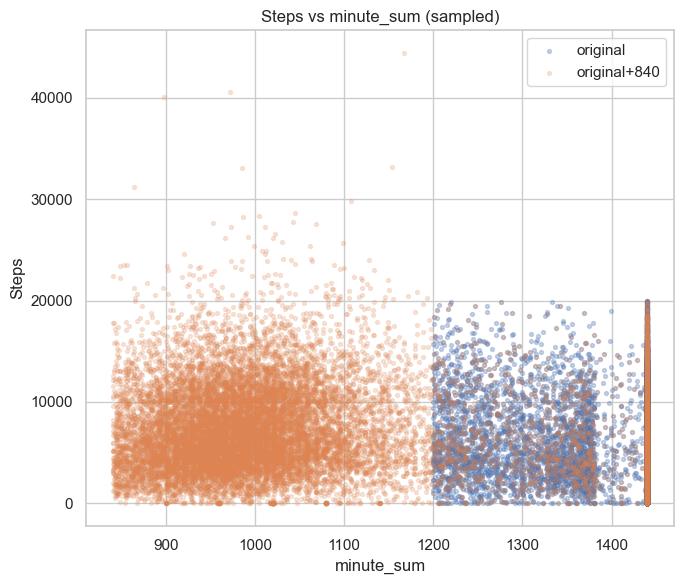


Per-participant counts comparison (top 20 by added_rows):


,Participant ID,ml_rows,plus_rows,added_rows,pct_change
43,54,40.0,433,393.0,982.500000
24,33,43.0,429,386.0,897.674419
27,37,0.0,379,379.0,NaN
134,2033,4.0,381,377.0,9425.000000
186,2104,2.0,376,374.0,18700.000000
119,2015,2.0,372,370.0,18500.000000
206,2128,8.0,375,367.0,4587.500000
109,2004,7.0,370,363.0,5185.714286
193,2112,6.0,369,363.0,6050.000000
167,2076,1.0,363,362.0,36200.000000



Comparison done. (All outputs displayed inline)


In [47]:
# Updated cell: diagnostics + inline display comparison between ML-ready and ML-ready_plus_840 (no file writes)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

base_dir = Path(r"c:\Users\chris\Documents\lab\mlife")
plots_dir = base_dir / 'data' / 'weird' / 'steps' / 'plots'
plots_dir.mkdir(parents=True, exist_ok=True)

ml_path = base_dir / 'data' / 'cleaned' / 'steps_no2109_ml_ready.csv'
plus_path = base_dir / 'data' / 'cleaned' / 'steps_no2109_ml_ready_plus_840.csv'

print('Loading datasets...')
df_ml = pd.read_csv(ml_path, parse_dates=['Date'])
df_plus = pd.read_csv(plus_path, parse_dates=['Date'])

# ensure numeric
for df in (df_ml, df_plus):
    if 'Steps' in df.columns:
        df['Steps'] = pd.to_numeric(df['Steps'], errors='coerce')
    if 'minute_sum' in df.columns:
        df['minute_sum'] = pd.to_numeric(df['minute_sum'], errors='coerce')

# Basic counts (display inline)
summary = []
for name, df in [('ml_ready', df_ml), ('ml_ready_plus_840', df_plus)]:
    s = {
        'dataset': name,
        'rows': int(len(df)),
        'participants': int(df['Participant ID'].nunique()) if 'Participant ID' in df.columns else None,
        'steps_non_na': int(df['Steps'].notna().sum()) if 'Steps' in df.columns else None,
        'steps_mean': float(df['Steps'].mean()) if 'Steps' in df.columns and df['Steps'].notna().any() else None,
        'steps_median': float(df['Steps'].median()) if 'Steps' in df.columns and df['Steps'].notna().any() else None,
        'steps_max': float(df['Steps'].max()) if 'Steps' in df.columns and df['Steps'].notna().any() else None,
        'pct_rows_minute_sum_1440': float((df.get('minute_sum', np.nan) == 1440).sum()) / max(1, len(df)) * 100
    }
    summary.append(s)
summary_df = pd.DataFrame(summary)
print('\nOverall summary:')
display(summary_df)

# Percentiles comparison for Steps and minute_sum (display inline)
percentiles = [0,1,5,10,25,50,75,90,95,99,100]
rows = []
for name, df in [('ml_ready', df_ml), ('ml_ready_plus_840', df_plus)]:
    for metric in ['Steps','minute_sum']:
        if metric in df.columns and df[metric].notna().any():
            vals = np.percentile(df[metric].dropna(), percentiles)
            for p,v in zip(percentiles, vals):
                rows.append({'dataset': name, 'metric': metric, 'percentile': p, 'value': float(v)})

perc_df = pd.DataFrame(rows)
print('\nPercentiles (Steps and minute_sum):')
display(perc_df.pivot_table(index=['percentile','metric'], columns='dataset', values='value'))

# Plots: Steps KDE/hist overlay (display inline)
plt.figure(figsize=(10,5))
sns.histplot(df_ml['Steps'].dropna(), color='C0', label='original', stat='density', bins=100, alpha=0.4)
sns.histplot(df_plus['Steps'].dropna(), color='C1', label='original+840', stat='density', bins=100, alpha=0.3)
plt.xlim(0, min(25000, max(df_ml['Steps'].dropna().max(), df_plus['Steps'].dropna().max())))
plt.xlabel('Steps')
plt.ylabel('Density')
plt.title('Steps distribution: ML-ready vs ML-ready_plus_840')
plt.legend()
plt.tight_layout();
plt.show()

# ECDF overlay (display inline)
plt.figure(figsize=(8,4))
for name, df, col in [('ml_ready', df_ml, 'C0'), ('ml_ready_plus_840', df_plus, 'C1')]:
    vals = np.sort(df['Steps'].dropna())
    y = np.arange(1, len(vals)+1)/len(vals)
    plt.plot(vals, y, label=name, color=col)
plt.xlim(0, min(25000, max(df_ml['Steps'].dropna().max(), df_plus['Steps'].dropna().max())))
plt.xlabel('Steps')
plt.ylabel('ECDF')
plt.title('ECDF of Steps: ML-ready vs plus_840')
plt.legend()
plt.tight_layout();
plt.show()

# minute_sum histograms overlay (if available)
if 'minute_sum' in df_ml.columns and 'minute_sum' in df_plus.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df_ml['minute_sum'].dropna(), color='C0', label='original', bins=60, alpha=0.5)
    sns.histplot(df_plus['minute_sum'].dropna(), color='C1', label='original+840', bins=60, alpha=0.4)
    plt.xlabel('minute_sum')
    plt.ylabel('Count')
    plt.title('minute_sum distribution: ML-ready vs plus_840')
    plt.legend()
    plt.tight_layout();
    plt.show()

# Steps vs minute_sum scatter (sampled for performance) — display inline
if 'minute_sum' in df_ml.columns and 'minute_sum' in df_plus.columns:
    sample_n = 20000
    a = df_ml[['minute_sum','Steps']].dropna()
    b = df_plus[['minute_sum','Steps']].dropna()
    a_s = a.sample(n=min(len(a), sample_n), random_state=1)
    b_s = b.sample(n=min(len(b), sample_n), random_state=1)
    plt.figure(figsize=(7,6))
    plt.scatter(a_s['minute_sum'], a_s['Steps'], alpha=0.3, s=8, label='original', color='C0')
    plt.scatter(b_s['minute_sum'], b_s['Steps'], alpha=0.2, s=8, label='original+840', color='C1')
    plt.xlabel('minute_sum')
    plt.ylabel('Steps')
    plt.title('Steps vs minute_sum (sampled)')
    plt.legend()
    plt.tight_layout();
    plt.show()

# Per-participant comparison: counts and change (display inline)
if 'Participant ID' in df_ml.columns:
    ml_counts = df_ml.groupby('Participant ID').size().reset_index(name='ml_rows')
    plus_counts = df_plus.groupby('Participant ID').size().reset_index(name='plus_rows')
    merged = ml_counts.merge(plus_counts, on='Participant ID', how='outer').fillna(0)
    merged['added_rows'] = merged['plus_rows'] - merged['ml_rows']
    merged['pct_change'] = merged['added_rows'] / merged['ml_rows'].replace({0:np.nan}) * 100
    print('\nPer-participant counts comparison (top 20 by added_rows):')
    display(merged.sort_values('added_rows', ascending=False).head(20))

print('\nComparison done. (All outputs displayed inline)')

Loading data...


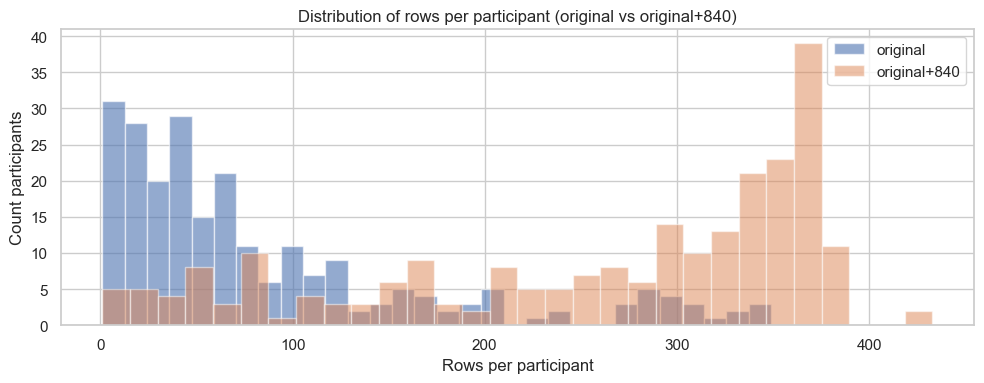

C:\Users\chris\AppData\Local\Temp\ipykernel_15300\3613113131.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant ID', y='ml_rows', data=ml_top20, ax=axes[0], palette='Blues_d')
C:\Users\chris\AppData\Local\Temp\ipykernel_15300\3613113131.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Participant ID', y='plus_rows', data=plus_top20, ax=axes[1], palette='Greens_d')


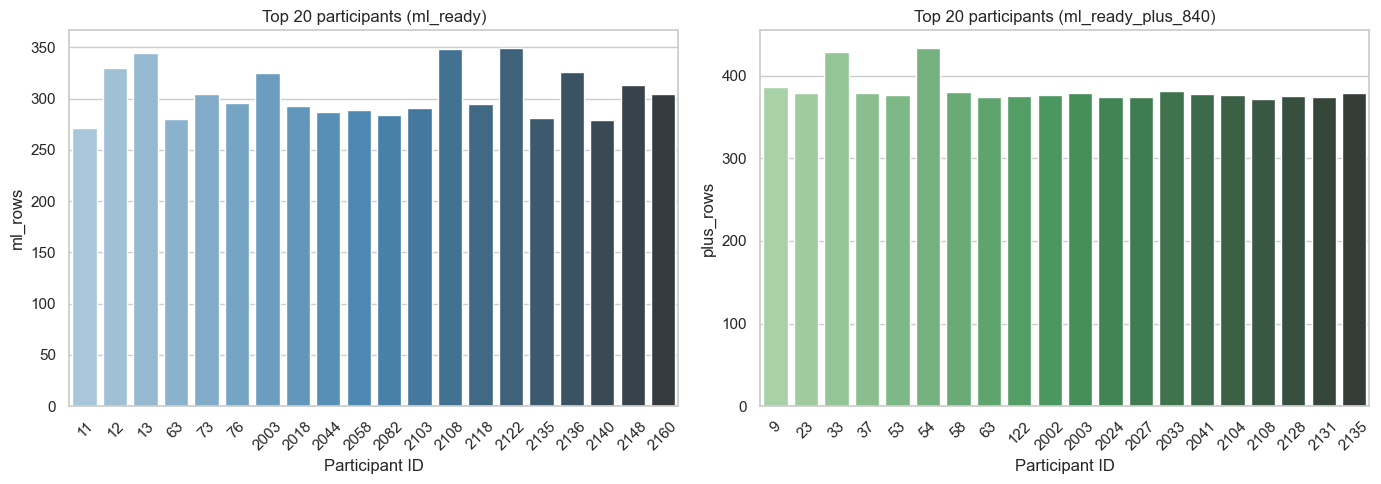


Sample of per-participant counts (top 30 by added_rows):
 Participant ID  ml_rows  plus_rows  added_rows
             54     40.0        433       393.0
             33     43.0        429       386.0
             37      0.0        379       379.0
           2033      4.0        381       377.0
           2104      2.0        376       374.0
           2015      2.0        372       370.0
           2128      8.0        375       367.0
           2004      7.0        370       363.0
           2112      6.0        369       363.0
           2076      1.0        363       362.0
           2054      9.0        371       362.0
           2047     10.0        371       361.0
             58     27.0        380       353.0
           2017      5.0        358       353.0
           2145      8.0        359       351.0
           2106     14.0        360       346.0
             41     21.0        366       345.0
           2024     31.0        374       343.0
             49     20.0      

In [49]:
# New cell: per-participant rows distribution plots (inline) for ML-ready and ML-ready_plus_840
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

base = Path(r"c:\Users\chris\Documents\lab\mlife")
ml_path = base / 'data' / 'cleaned' / 'steps_no2109_ml_ready.csv'
plus_path = base / 'data' / 'cleaned' / 'steps_no2109_ml_ready_plus_840.csv'

print('Loading data...')
df_ml = pd.read_csv(ml_path)
df_plus = pd.read_csv(plus_path)

# compute per-participant counts
ml_counts = df_ml.groupby('Participant ID').size().reset_index(name='ml_rows')
plus_counts = df_plus.groupby('Participant ID').size().reset_index(name='plus_rows')

# Histogram of rows per participant (side-by-side)
plt.figure(figsize=(10,4))
plt.hist(ml_counts['ml_rows'], bins=30, alpha=0.6, label='original')
plt.hist(plus_counts['plus_rows'], bins=30, alpha=0.5, label='original+840')
plt.xlabel('Rows per participant')
plt.ylabel('Count participants')
plt.title('Distribution of rows per participant (original vs original+840)')
plt.legend()
plt.tight_layout()
plt.show()

# Top 20 bar charts side-by-side
ml_top20 = ml_counts.sort_values('ml_rows', ascending=False).head(20)
plus_top20 = plus_counts.sort_values('plus_rows', ascending=False).head(20)

fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=False)
sns.barplot(x='Participant ID', y='ml_rows', data=ml_top20, ax=axes[0], palette='Blues_d')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('Top 20 participants (ml_ready)')

sns.barplot(x='Participant ID', y='plus_rows', data=plus_top20, ax=axes[1], palette='Greens_d')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title('Top 20 participants (ml_ready_plus_840)')

plt.tight_layout()
plt.show()

# Show a small table comparing counts for participants present in either dataset
merged = ml_counts.merge(plus_counts, on='Participant ID', how='outer').fillna(0)
merged['added_rows'] = merged['plus_rows'] - merged['ml_rows']
print('\nSample of per-participant counts (top 30 by added_rows):')
print(merged.sort_values('added_rows', ascending=False).head(30).to_string(index=False))

print('\nDone')